<a href="https://colab.research.google.com/github/rasoco/master_data_science/blob/master/TFM/BiciMadProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiciMad Project  - Master Data Science KSchool Ed.019



## Conect with GPU of Google 



In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('Encontrada GPU: {}'.format(device_name))

Encontrada GPU: /device:GPU:0


In [2]:
# !pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
drive

In [4]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploration and cleaning Madrid Stations

###Load of the libraries


In [5]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium # To display maps with coordinates and markers.
import geopy # For geocoding and reverse geocoding.


### Load of the Madrid Stations dataset


In [6]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/originalbikestations.csv", sep=';', encoding='utf-8') #decimal is okey
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Número            216 non-null    object 
 1   Gis_X             216 non-null    object 
 2   Gis_Y             216 non-null    object 
 3   Fecha de Alta     216 non-null    object 
 4   Distrito          216 non-null    object 
 5   Barrio            216 non-null    object 
 6   Calle             216 non-null    object 
 7   Nº Finca          216 non-null    object 
 8   Tipo de Reserva   216 non-null    object 
 9   Número de Plazas  216 non-null    int64  
 10  Unnamed: 10       0 non-null      float64
 11  LONGITUD          216 non-null    float64
 12  LATITUD           216 non-null    float64
 13  DIRECCION         216 non-null    object 
dtypes: float64(3), int64(1), object(10)
memory usage: 23.8+ KB


In [7]:
del df['Unnamed: 10']

In [8]:
df['Year'] = pd.DatetimeIndex(df['Fecha de Alta']).year
year = df['Year']
df = df.rename(columns = {'Número':'id','Número de Plazas':'Anclajes'}) #change de name of column Número
df.head()

,id,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Anclajes,LONGITUD,LATITUD,DIRECCION,Year
0,001 a,"440443,61","4474290,65",04/12/2019,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",2,BiciMAD,30,-3.701998,40.417111,"CALLE DE ALCALA, 2",2019
1,001 b,"440480,56","4474301,74",06/02/2020,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",6,BiciMAD,30,-3.701564,40.417213,"CALLE DE ALCALA, 6",2020
2,2,"440134,83","4474678,23",23/06/2014,01 CENTRO,01-05 UNIVERSIDAD,"MIGUEL MOYA, CALLE, DE",1,BiciMAD,24,-3.705674,40.420580,"CALLE DE MIGUEL MOYA, 1",2014
3,3,"440012,98","4475760,68",23/06/2014,07 CHAMBERÍ,07-02 ARAPILES,"CONDE DEL VALLE DE SUCHIL, PLAZA, DEL",2,BiciMAD,18,-3.707212,40.430323,"PLAZA DEL CONDE DEL VALLE DE SUCHIL, 2",2014
4,4,"440396,4","4475565,36",23/06/2014,01 CENTRO,01-05 UNIVERSIDAD,"MANUELA MALASAÑA, CALLE, DE",3,BiciMAD,24,-3.702674,40.428591,"CALLE DE MANUELA MALASAÑA, 3",2014


In [9]:
df.columns

Index(['id', 'Gis_X', 'Gis_Y', 'Fecha de Alta', 'Distrito', 'Barrio', 'Calle',
       'Nº Finca', 'Tipo de Reserva', 'Anclajes', 'LONGITUD', 'LATITUD',
       'DIRECCION', 'Year'],
      dtype='object')

In [10]:
df['ids'] = df['id'].str.rstrip('ampliacionb') #to get only number values
# df_stations = df_stations[onlycolumns]
df['ids'] = df['ids'].astype(int).sort_values() #change values ids and order
df.head()

,id,Gis_X,Gis_Y,Fecha de Alta,Distrito,Barrio,Calle,Nº Finca,Tipo de Reserva,Anclajes,LONGITUD,LATITUD,DIRECCION,Year,ids
0,001 a,"440443,61","4474290,65",04/12/2019,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",2,BiciMAD,30,-3.701998,40.417111,"CALLE DE ALCALA, 2",2019,1
1,001 b,"440480,56","4474301,74",06/02/2020,01 CENTRO,01-06 SOL,"ALCALA, CALLE, DE",6,BiciMAD,30,-3.701564,40.417213,"CALLE DE ALCALA, 6",2020,1
2,2,"440134,83","4474678,23",23/06/2014,01 CENTRO,01-05 UNIVERSIDAD,"MIGUEL MOYA, CALLE, DE",1,BiciMAD,24,-3.705674,40.420580,"CALLE DE MIGUEL MOYA, 1",2014,2
3,3,"440012,98","4475760,68",23/06/2014,07 CHAMBERÍ,07-02 ARAPILES,"CONDE DEL VALLE DE SUCHIL, PLAZA, DEL",2,BiciMAD,18,-3.707212,40.430323,"PLAZA DEL CONDE DEL VALLE DE SUCHIL, 2",2014,3
4,4,"440396,4","4475565,36",23/06/2014,01 CENTRO,01-05 UNIVERSIDAD,"MANUELA MALASAÑA, CALLE, DE",3,BiciMAD,24,-3.702674,40.428591,"CALLE DE MANUELA MALASAÑA, 3",2014,4


In [11]:
df['ids'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  65,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

### Exploration of data


#### Grouping Distrito and show values unique and not unique of "id"

In [12]:
df.groupby('Distrito')['ids']\
      .agg(['nunique', 'unique'])\
      .sort_values(by='nunique', ascending=False)

,nunique,unique
Distrito,,
01 CENTRO,57,"[1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, ..."
04 SALAMANCA,37,"[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9..."
03 RETIRO,26,"[60, 61, 62, 63, 65, 68, 69, 70, 71, 72, 73, 7..."
07 CHAMBERÍ,24,"[3, 8, 111, 122, 123, 124, 125, 126, 127, 128,..."
02 ARGANZUELA,22,"[46, 47, 118, 119, 120, 121, 162, 163, 164, 16..."
05 CHAMARTÍN,18,"[136, 137, 139, 140, 146, 147, 148, 149, 150, ..."
06 TETUÁN,11,"[133, 151, 152, 153, 154, 155, 156, 204, 205, ..."
09 MONCLOA-ARAVACA,9,"[14, 110, 112, 113, 114, 115, 116, 117, 161]"
15 CIUDAD LINEAL,2,"[188, 189]"


In [13]:
# df.groupby('OBJECTID')['OBJECTID'].agg(['nunique','unique'])
# df.groupby('Estación')['Estación'].agg(['unique'])

In [14]:
def agrupation(b,c):
    # b = ""
    # c = ""
    a = df.groupby('b')['c'].agg(['nunique','unique'])
    print(a)


In [15]:
# Name of values unique of Distrito
df['Distrito'].unique()

array(['01 \xa0CENTRO', '07 \xa0CHAMBERÍ', '09 \xa0MONCLOA-ARAVACA',
       '02 \xa0ARGANZUELA', '03 \xa0RETIRO', '04 \xa0SALAMANCA',
       '06 \xa0TETUÁN', '05 \xa0CHAMARTÍN', '13 \xa0PUENTE DE VALLECAS',
       '15 \xa0CIUDAD LINEAL'], dtype=object)

In [16]:
# # Change the name of Distrito

# distrito_bike = ['01 CENTRO', '02 ARGANZUELA'. '03 RETIRO', '04 SALAMANCA', '05 CHAMARTÍN', '06 TETUÁN', '07 CHAMBERÍ', '09 MONCLOA - ARAVACA']
# df['distrito'] = df[distrito_bike]
# bikestations['WKT'] = bikestations[['X','Y']].apply(lambda x: ''.join(x), axis=1)
# # bikestations['p'] = df[['Year', 'quarter']].apply(lambda x: ''.join(x), axis=1)

# bikestations['WKT'] = bikestations.X.str.cat(bikestations.Y)

# import folium
# # from folium.plugins import MarkerCluster
# import pandas as pd
 
# SF_COORDINATES = (-3.701305, 40.418893)
# df
 
# # for speed purposes
# MAX_RECORDS = 170
  
# # create empty map zoomed in on San Francisco
# mapa = folium.Map(location=SF_COORDINATES, zoom_start=12)
# marker_cluster = folium.Marker().add_to(mapa) 

 
# # add a marker for every record in the filtered data, use a clustered view
# for each in df[0:MAX_RECORDS].iterrows():
#     folium.Marker(
#         location = [each[0]['Y'],each[0]['X']], 
#         clustered_marker = True).add_to(marker_cluster)
  
# display(mapa)

# for each in df[0:MAX_RECORDS].iterrows():
#   print(each[1,2])
#     # folium.Marker(
#     #     location = [each[0]['Y'],each[0]['X']], 
#     #     clustered_marker = True).add_to(marker_cluster)

# import folium
# from folium.plugins import MarkerCluster

# map1 = folium.Map(location=SF_COORDINATES, zoom_start=12)
# marker_cluster = MarkerCluster().add_to(map1) 

# for each in data[0:MAX_RECORDS].iterrows():
#     map1.Marker(location = [each[1]['Y'],each[1]['X']], 
#     clustered_marker = True).add_to(marker_cluster)

# display(map1)

# import requests 
# import os 
# def coord(c):
#     coor = re.compile(r'-?\d+\.\d{7}', c)
#     coords = [float(s) for s in coor]
#     return coords[::-1]

# bikestations['X'] = bikestations['X'].apply(coord)

# # filtramos solo las bicicleterías de palermo
# bici_centro = bikestations[bikestations.Distrito == '01 CENTRO'][['X', 'Y', 'Anclajes']]

#### Analysis of total Barrio per Distrito


In [17]:
d_b = df.groupby(['Distrito'])['Barrio'].count()
d_b


Distrito
01  CENTRO                60
02  ARGANZUELA            22
03  RETIRO                27
04  SALAMANCA             38
05  CHAMARTÍN             18
06  TETUÁN                11
07  CHAMBERÍ              26
09  MONCLOA-ARAVACA       11
13  PUENTE DE VALLECAS     1
15  CIUDAD LINEAL          2
Name: Barrio, dtype: int64

#### Show graphic of the Bike Station by Distrito

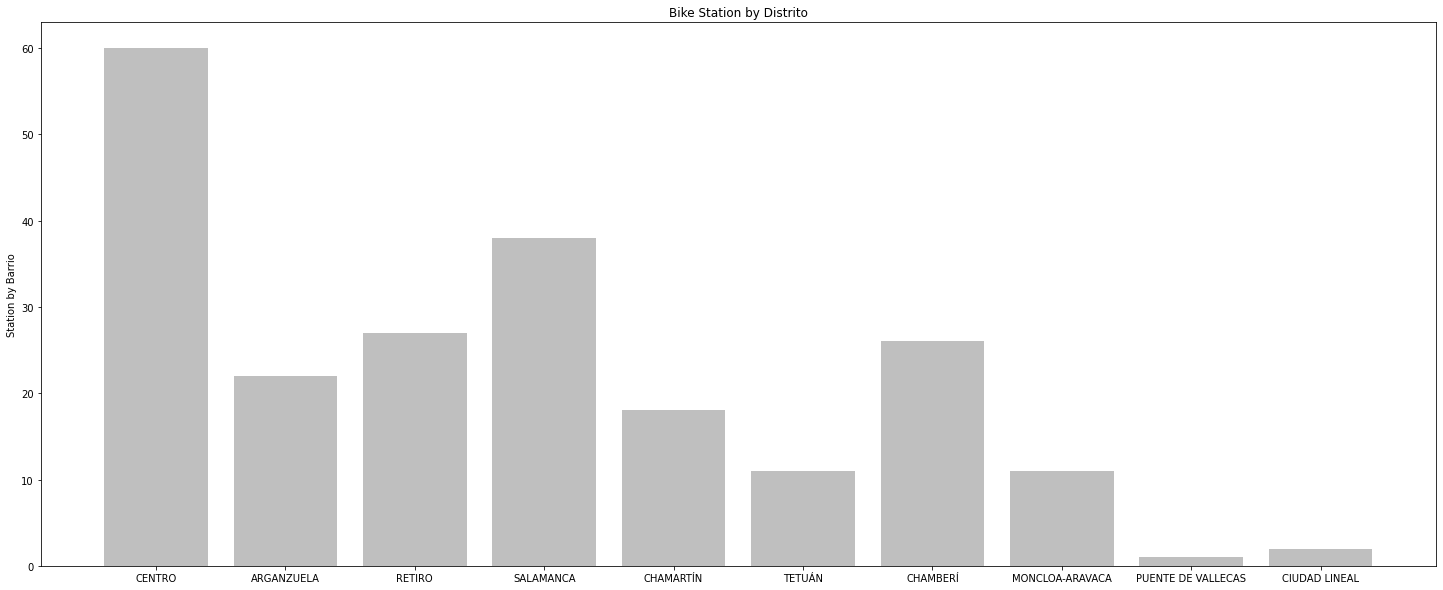

In [18]:
import matplotlib.pyplot as plt
# fig = plt.figure()
# fig.add_axes(langs)
langs = ['CENTRO', 'ARGANZUELA', 'RETIRO', 'SALAMANCA', 'CHAMARTÍN', 'TETUÁN', 'CHAMBERÍ', 'MONCLOA-ARAVACA', 'PUENTE DE VALLECAS', 'CIUDAD LINEAL']
# ax.bar(langs,aa)
# plt.show()
fig=plt.figure()
fig.set_figheight(10)
fig.set_figwidth(25)
fig.set_facecolor('white')
y_pos = np.arange(len(langs))
plt.bar(y_pos, d_b, align='center', alpha=0.5, width=0.8, color = 'gray')
plt.xticks(y_pos, langs)
plt.ylabel('Station by Barrio')
plt.title('Bike Station by Distrito')

plt.show()

In [19]:
df.groupby('Distrito')['Anclajes'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)

,count,sum,mean
Distrito,,,
01 CENTRO,60,1419,23.650000
04 SALAMANCA,38,906,23.842105
03 RETIRO,27,664,24.592593
07 CHAMBERÍ,26,584,22.461538
02 ARGANZUELA,22,541,24.590909
05 CHAMARTÍN,18,426,23.666667
06 TETUÁN,11,258,23.454545
09 MONCLOA-ARAVACA,11,243,22.090909
15 CIUDAD LINEAL,2,51,25.500000


#### Total Anclaje by Year

In [20]:
df.groupby('Year')['Anclajes'].agg(['sum'])

,sum
Year,
2014,2872
2015,939
2016,24
2017,44
2018,15
2019,1147
2020,75


In [21]:
df['Anclajes'].sum()

5116

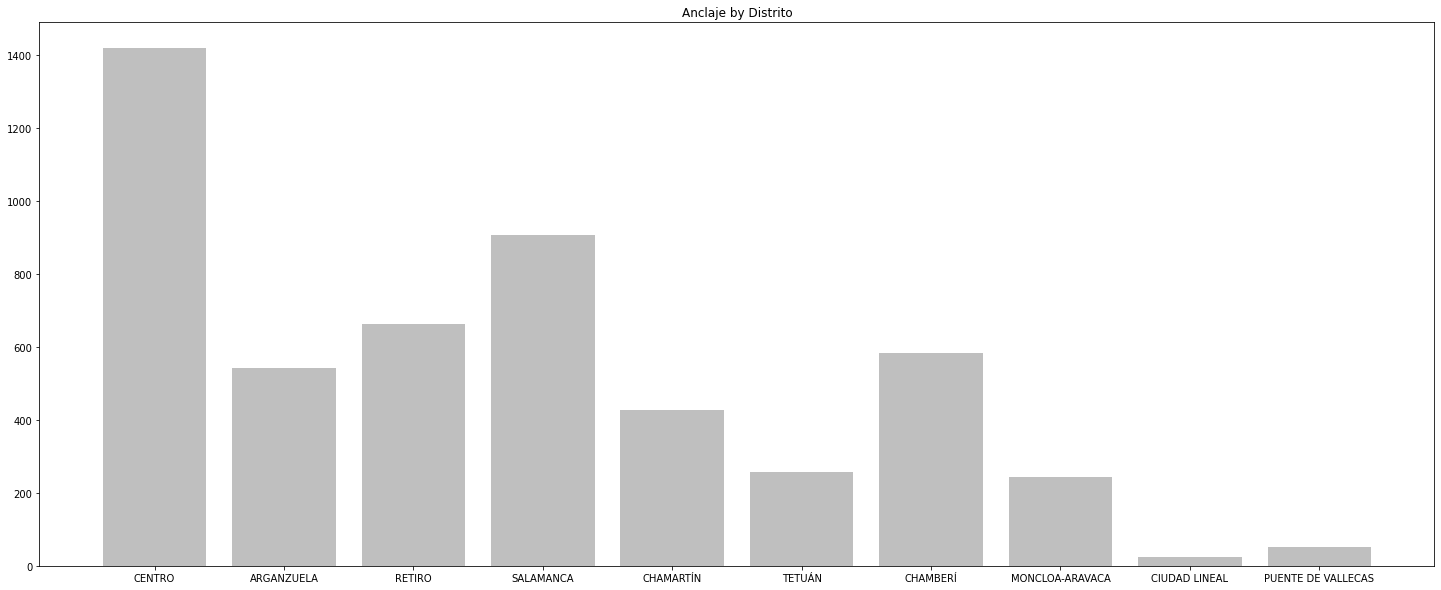

In [22]:
d_a = df.groupby('Distrito')['Anclajes'].sum()
langs = ['CENTRO', 'ARGANZUELA', 'RETIRO', 'SALAMANCA', 'CHAMARTÍN', 'TETUÁN', 'CHAMBERÍ', 'MONCLOA-ARAVACA', 'CIUDAD LINEAL', 'PUENTE DE VALLECAS']
# ax.bar(langs,aa)
# plt.show()
fig=plt.figure()
fig.set_figheight(10)
fig.set_figwidth(25)
fig.set_facecolor('white')
y_pos = np.arange(len(langs))
plt.bar(y_pos, d_a, align='center', alpha=0.5, width=0.8, color = 'gray')
plt.xticks(y_pos, langs)
# plt.ylabel('Anclaje by Disti')
plt.title('Anclaje by Distrito')

plt.show()

In [23]:
df.columns

Index(['id', 'Gis_X', 'Gis_Y', 'Fecha de Alta', 'Distrito', 'Barrio', 'Calle',
       'Nº Finca', 'Tipo de Reserva', 'Anclajes', 'LONGITUD', 'LATITUD',
       'DIRECCION', 'Year', 'ids'],
      dtype='object')

Text(0.5, 1.0, 'Total de Anclajes por Distrito y Año')

<Figure size 3600x10800 with 0 Axes>

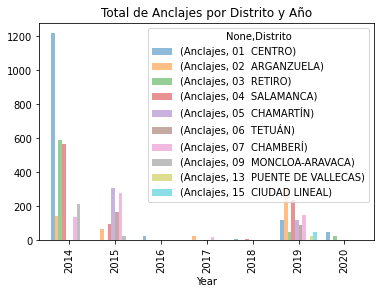

In [24]:
year_distrito = df.groupby(['Year','Distrito']).agg({'Anclajes': 'sum'})
fig1=plt.figure()
# rect = l,b,w,h
# fig1.add_axes(rect, frameon=False, axisbg='g')
# fig1.add_axes([2014, 2015, 2016, 2017, 2018, 2019, 2020])
# fig1.subplots_adjust(wspace=0.9, hspace=0.9)
fig1.set_figheight(150)
fig1.set_figwidth(50)
fig.set_facecolor('white')
# plt.bar(align='center', alpha=0.5, width=0.8, color = 'gray')

year_distrito.unstack().plot.bar(align='center', alpha=0.5, width=0.8)
plt.title("Total de Anclajes por Distrito y Año")


In [25]:
# plt.figure(figsize=[10,8])
# # x=d_a
# # x=d_b
# # n,bins,pat.hist([x,y])

# plt.hist([d_a,d_b])

In [26]:
d_e = df.groupby('id')['Distrito'].sum()
d_e

id
001 a                01  CENTRO
001 b                01  CENTRO
020 ampliacion       01  CENTRO
025 a                01  CENTRO
025 b                01  CENTRO
                      ...      
95                04  SALAMANCA
96                04  SALAMANCA
97                04  SALAMANCA
98                04  SALAMANCA
99                04  SALAMANCA
Name: Distrito, Length: 216, dtype: object

### Maps

  #### Get of coordinates (Longitude and Latitude)








In [ ]:
locations = df[['LATITUD', 'LONGITUD']] # (Y, X)
locationlist = locations.values.tolist()
len(locationlist)
# locationlist 


216

In [ ]:
df['Locationlist'] = locationlist

#### Scatterplot of X, Y

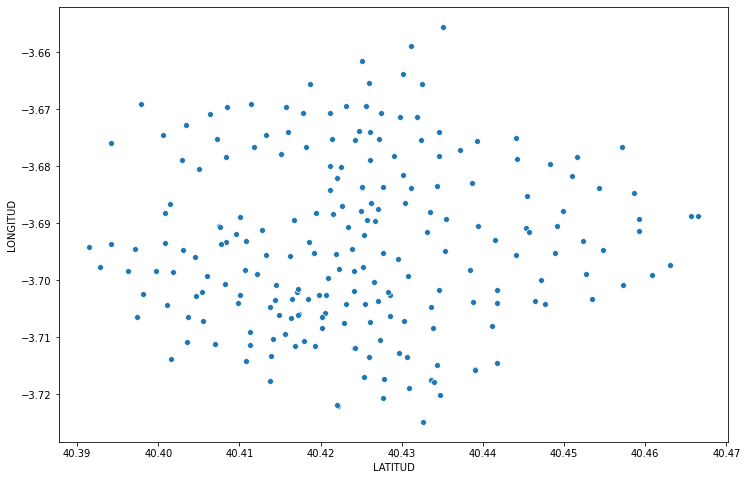

In [ ]:
plt.figure(figsize = (12,8))
sns.scatterplot(df['LATITUD'], df['LONGITUD'])

#### Testing of map

In [ ]:
import pandas as pd
import numpy as np
# import streamlit as st
import matplotlib.pyplot as plt
# import folium.plugins
# import plotly.express as px
from folium.plugins import MarkerCluster
# from bokeh.plotting import figure, output_file, show
# from streamlit_folium import folium_static

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/originalbikestations.csv", sep=';', encoding='utf-8')
df['Year'] = pd.DatetimeIndex(df['Fecha de Alta']).year
year = df['Year']
df = df.rename(columns = {'Número':'id','Número de Plazas':'Anclajes'}) #change de name of column Número
df['ids'] = df['id'].str.rstrip('ampliacionb') #to get only number values
# df_stations = df_stations[onlycolumns]
df['ids'] = df['ids'].astype(int).sort_values() #change values ids and order

d_b = df.groupby(['Distrito'])['Barrio'].count()

locations = df[['LATITUD', 'LONGITUD']] # (Y, X)
locationlist = locations.values.tolist()
df['Locationlist'] = locationlist

map1 = folium.Map(location=[40.417110795315295, -3.70199802576925], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['id'][point], icon=folium.Icon(color='darkblue', icon_color='white', icon='bicycle', angle=0, prefix='fa')).add_to(map1)
map1  

In [ ]:
df.columns

Index(['id', 'Gis_X', 'Gis_Y', 'Fecha de Alta', 'Distrito', 'Barrio', 'Calle',
       'Nº Finca', 'Tipo de Reserva', 'Anclajes', 'Unnamed: 10', 'LONGITUD',
       'LATITUD', 'DIRECCION', 'Year', 'ids', 'Locationlist'],
      dtype='object')

#### Display of bike map in Madrid

In [ ]:
map1 = folium.Map(location=[40.417110795315295, -3.70199802576925], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['id'][point], icon=folium.Icon(color='darkblue', icon_color='white', icon='bicycle', angle=0, prefix='fa')).add_to(map1)
map1  

#### Display of BikeMadrid per Distrito

In [ ]:
import folium.plugins
folium.plugins.MarkerCluster()
map2 = folium.Map(location=[40.417110795315295, -3.70199802576925], tiles='Stamen Terrain', zoom_start=11)

marker_cluster = folium.plugins.MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['Distrito'][point], icon=folium.Icon(color='darkblue', icon_color='green', icon='bicycle', angle=0, prefix='fa')).add_to(marker_cluster)
map2

In [ ]:
import plotly.express as px
fig = px.scatter_geo(df, locations=df['Locationlist'], locationmode='country names', color= df['Distrito'].sort_values(), hover_name=df['Calle'],
                     size=df['Anclajes'], scope='europe', 
                     animation_frame=df['Year'].sort_values(), 
                     projection='stereographic')
# (df, locations="Locationlist", hover_name="Distrito", animation_frame="Year", projection="natural earth")
fig.show()

### Machine Learning 

#### Transformation is to convert the latitude and longitude to radians instead of degrees

In [ ]:
import numpy as np
df["X"] = np.radians(df["LONGITUD"]) # add new columns with transformation to radians
X = df['X']
df["Y"] = np.radians(df["LATITUD"])
Y = df['Y']

#### Unsupervised Model using AgglomerativeClustering (Model1)

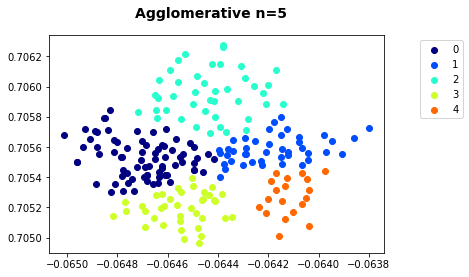

In [ ]:
from sklearn import cluster
df["X"] = np.radians(df["LONGITUD"]) # add new columns with transformation to radians
X = df['X']
df["Y"] = np.radians(df["LATITUD"])
Y = df['Y']

data = df[["X", "Y"]]

hclust1 = cluster.AgglomerativeClustering(n_clusters=5)
label = hclust1.fit_predict(data)
df['cluster1'] = label

fig = plt.figure()
fig.suptitle('Agglomerative n=5', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)

clusters = list(set(label))

for i in range(len(clusters)):
  plt.scatter(df[df.cluster1 == clusters[i]].X, df[df.cluster1 == clusters[i]].Y, 
                label=i, color=plt.cm.jet(np.float(i) / len(np.unique(label))))

plt.legend(bbox_to_anchor=(1.25, 1))

In [ ]:
# from sklearn.neighbors.nearest_centroid import NearestCentroid
# clf1 = NearestCentroid()
# clf1.fit_(data)
# centroids1 = clf1.centroids_

In [ ]:
sse_model1 = np.sum(np.square(np.linalg.norm(Y.values - centroids1[clusters], axis=1)))
sse_model1

NameError: ignored

#### Unsupervised Model using KMeans Clustering (Model2)

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
y = np.radians(df["LATITUD"]) #series
x =  np.radians(df[["LONGITUD"]]) #dataframe

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)
KMeans = KMeans(n_clusters=5)
model2 = KMeans.fit(x_train, y_train)
model2 = KMeans.fit_predict(x_test)

# df['cluster2'] = model2m

In [ ]:
centroids2 = pd.DataFrame(KMeans.cluster_centers_)
labels = pd.DataFrame(KMeans.labels_)

In [ ]:
type(centroids2)

pandas.core.frame.DataFrame

In [ ]:
type(x_train)

pandas.core.frame.DataFrame

In [ ]:
sse_model2 = KMeans.inertia_
sse_model2

1.731533300402568e-07

In [ ]:
# K = 5
# figure = plt.figure(figsize=(10,7))
# plt.scatter(x_train, y_train, cmap="plasma", linewidths=1);
# for k in range(K):
#   plt.scatter(centroids2[k,0], centroids2[k, 1], s=100, marker='*', color='red')

# plt.show()

In [ ]:
# # DON'T WORK
# figure = plt.figure(figsize=(10,7))
# for i, l in enumerate(KMeans.labels_):
#   plt.plot(x_train[i], y_train[i], color=colos[l], marker=markers[l], ls="None")
# plt.scatter(centroids2[:,0], centroids[:,1], marker="*", color="r")
# plt.show()

In [ ]:
# DON'T WORK
# colors = ["green", "red"]
# K = 5
# figure = plt.figure(figsize=(10,7))
# plt.scatter(x_train.iloc[:,0], y_train.iloc[:,1], c=np.array(colors)[labels], s = 10, alpha=.1)
# plt.scatter(centroids2[:,0], centroids2[:,1], s=100, marker='*', color=["green", "red"])

# plt.show()

#### Unsupervised Model using AgglomerativeClustering (Model3)

In [ ]:
from sklearn import cluster
from sklearn.model_selection import train_test_split


y = np.radians(df["LATITUD"]) #series
x =  np.radians(df[["LONGITUD"]]) #dataframe

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

model3 = cluster.AgglomerativeClustering(n_clusters=5)
model3.fit(x_train,y_train)

model3.labels_
y_pred = model3.fit_predict(x_test)

In [ ]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
clf3 = NearestCentroid()
clf3.fit(x_test, y_pred)
centroids3 = clf3.centroids_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
sse_model3 = np.sum(np.square(np.linalg.norm(y_train.values - centroids3, axis=1)))
sse_model3

447.59541941981945

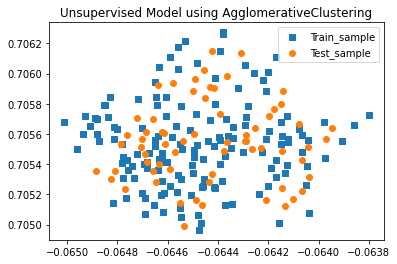

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x_train, y_train, marker="s", label="Train_sample")
ax1.scatter(x_test, y_test, marker="o", label="Test_sample")
plt.legend(loc="upper right")
plt.title("Unsupervised Model using AgglomerativeClustering")
plt.show()

#### Elbow Method

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 5 random clusters
X, y = make_blobs(n_samples=1000, n_features=5, centers=5, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,10))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()  

#### Metrics: Sum of Square Error

In [ ]:
sse_model2

1.731533300402568e-07

In [ ]:
sse_model3

447.59541941981945

In [ ]:
# data = df['pickup cluster']
# # Sum of Squared Error

# # np.sum(np.square(np.linalg.norm(df['pickup cluster'] - centroids[clusters], axis=1)))
# def sse(data, clusters, centroids):
#     return np.sum(np.square(np.linalg.norm(data - centroids[clusters], axis=1))) 

# ks = range(2, 20)
# sse_errors = np.zeros(len(ks))

# for i, k in enumerate(ks):
#     # clusters_, centroids_ = kmeans(df['pickup cluster'], k)
#     sse_errors[i] = sse(df['pickup cluster'], clusters, centroids)
#     print(k, sse_errors[i])

### Only Stations 2019

In [27]:
stations_2019 = df[df['Year'] <= 2019] #save the 2019 stations data for use to jan18
stations_2019['idunplug_station'] = stations_2019['ids']
stations_2019['idplug_station'] = stations_2019['ids']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Exploration and cleaning Jan18 Dataset

####Load of Libraries

In [28]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn 

####Acquiring data

In [29]:
downloaded = drive.CreateFile({'id':'1dBJtPkHMvyF5Pmeu-w8z-Y91smROB_6b'})
downloaded.GetContentFile('jan18.json')
# downloaded.GetContentFile('jan18_clean.json')

In [30]:
print(os.getcwd)

<built-in function getcwd>


#### Reading and Exploring data

In [31]:
jan18 = pd.read_json("jan18.json",encoding="utf-8", lines=True, dtype='frame')# open de file

In [32]:
jan18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263702 entries, 0 to 263701
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   _id               263702 non-null  object
 1   user_day_code     263702 non-null  object
 2   idplug_base       263702 non-null  int64 
 3   user_type         263702 non-null  int64 
 4   idunplug_base     263702 non-null  int64 
 5   travel_time       263702 non-null  int64 
 6   idunplug_station  263702 non-null  int64 
 7   ageRange          263702 non-null  int64 
 8   idplug_station    263702 non-null  int64 
 9   unplug_hourTime   263702 non-null  object
 10  zip_code          263702 non-null  object
dtypes: int64(7), object(4)
memory usage: 22.1+ MB


In [33]:
# Save of position in _id column 
position = dict(enumerate(jan18['_id'].values))
position
type(position)
ids = []
# Save of values in its position 
ids = []
for d, v in position.items():
    ids += list(v.values())
#Save in the column _id
jan18['_id'] = ids 

In [34]:
na_columns = ['_id', 'user_day_code', 'idunplug_station', 'idunplug_base', 'idplug_station', 'idplug_base',
   'user_type','travel_time','unplug_hourTime', 'ageRange', 'zip_code']
jan18 = jan18[na_columns]
jan18 = jan18.rename(columns = {'_id':'id'})

# jan18.columns = ['_id', 'user_day_code', 'idunplug_base','idunplug_station','idplug_base', 'idplug_station',
#        'user_type','travel_time','unplug_hourTime', 'ageRange', 'zip_code']

In [35]:
# jan18.to_csv('jan18_clean.csv') # to save the dataset

In [36]:
jan18.head(1000)

,id,user_day_code,idunplug_station,idunplug_base,idplug_station,idplug_base,user_type,travel_time,unplug_hourTime,ageRange,zip_code
0,5a505acd2f384319304ed614,b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64...,6,14,7,1,1,284,{'$date': '2018-01-01T00:00:00.000+0100'},5,28010
1,5a505acd2f384319304ed615,65a82ac6353d9e8b25c17a49bb46d09426757b40946370...,24,21,117,4,1,666,{'$date': '2018-01-01T00:00:00.000+0100'},0,
2,5a505acd2f384319304ed616,51b7da733980586e1f847b61cc4af9c0268fc2d09df63e...,24,19,117,19,1,662,{'$date': '2018-01-01T00:00:00.000+0100'},0,
3,5a505acd2f384319304ed617,0af09bb0e23045fb7328123044822a0eb9cf154d644a96...,82,2,110,1,1,708,{'$date': '2018-01-01T00:00:00.000+0100'},3,28005
4,5a505acd2f384319304ed619,500e6780660a1fb237f8e5410992296141a46b141ed3ff...,169,3,58,5,1,171,{'$date': '2018-01-01T00:00:00.000+0100'},4,28004
...,...,...,...,...,...,...,...,...,...,...,...
995,5a505ad12f384319304eda71,9a81bb7bb1387b1f8b8b1a7aa6ca1480bce52f9f200017...,17,13,149,1,1,521,{'$date': '2018-01-01T06:00:00.000+0100'},4,28003
996,5a505ad12f384319304eda73,1720f4676d55c2dff9707ad03792e832943de8c20faa27...,166,24,103,23,1,338,{'$date': '2018-01-01T06:00:00.000+0100'},3,28009
997,5a505ad12f384319304eda72,8c088f94ff94c5dbed094c45f7e80210a13910017a0b49...,5,19,170,3,1,1113,{'$date': '2018-01-01T06:00:00.000+0100'},0,
998,5a505ad12f384319304eda74,7bf4c6de14f6289c6fb33663b93fa5f723a7fc5a080e6e...,14,22,26,3,1,341,{'$date': '2018-01-01T06:00:00.000+0100'},4,28001


In [37]:
# jan18[jan18['idplug_station'] == 2008] #show the result

In [38]:
jan18 = jan18.drop(jan18[jan18.idplug_station == 2008].index) #deleting values 2008

In [39]:
jan18.isna().sum()

id                  0
user_day_code       0
idunplug_station    0
idunplug_base       0
idplug_station      0
idplug_base         0
user_type           0
travel_time         0
unplug_hourTime     0
ageRange            0
zip_code            0
dtype: int64

In [40]:
# About null 
jan18.isnull().sum()

id                  0
user_day_code       0
idunplug_station    0
idunplug_base       0
idplug_station      0
idplug_base         0
user_type           0
travel_time         0
unplug_hourTime     0
ageRange            0
zip_code            0
dtype: int64

# Unification processing Dataset (Jan18 and Stations_2019)

####Proceso Unificado

In [41]:
new_dataset = pd.merge(jan18, stations_2019, on='idunplug_station')
new_dataset = new_dataset.rename(columns={'Gis_X':'Gis_Xidunplug',
       'Gis_Y':'Gis_Yidunplug', 'Fecha de Alta':'Fecha de Alta_idunplug', 'Distrito':'Distrito_idunplug', 'Barrio':'Barrio_idunplug', 'Calle':'Calle_idunplug', 'Nº Finca':'Nº Finca_idunplug',
        'Anclajes':'Anclajes_idunplug', 'Longitud':'Longitud_idunplug', 'Latitud':'Latitud_idunplug', 'DIRECCION':'DIRECCION_idunplug',
       'Year':'Year_idunplug', 'Locationlist':'Locationlist_idunplug', 'X':'X_idunplug', 'Y':'Y_idunplug'}) #change de name of the columns

del new_dataset['ids']
another_dataset = pd.merge(jan18,stations_2019, on = 'idplug_station')

another_dataset = another_dataset.rename(columns={'Gis_X':'Gis_Xidplug',
       'Gis_Y':'Gis_Yidplug', 'Fecha de Alta':'Fecha de Alta_idplug', 'Distrito':'Distrito_idplug', 'Barrio':'Barrio_idplug', 'Calle':'Calle_idplug', 'Nº Finca':'Nº Finca_idplug',
        'Anclajes':'Anclajes_idplug', 'Longitud':'Longitud_idplug', 'Latitud':'Latitud_idplug', 'DIRECCION':'DIRECCION_idplug',
       'Year':'Year_idplug', 'Locationlist':'Locationlist_idplug', 'X':'X_idplug', 'Y':'Y_idplug'})
del another_dataset['ids']

another_dataset.to_csv("another_dataset")
new_dataset.to_csv("new_dataset")# to save
new_dataset = pd.merge(jan18, stations_2019, on='idunplug_station') #join jan18 and stations_2019 using idunplug_station

join_data = pd.merge(new_dataset, another_dataset, on=['user_day_code'])

In [ ]:
# another_dataset = pd.merge(jan18,stations_2019, on = 'idplug_station', indicator=True, how='left') #que tipo de merge hace en cada fila 
another_dataset.head(2)

,id_x,user_day_code,idunplug_station_x,idunplug_base,idplug_station,idplug_base,user_type,travel_time,unplug_hourTime,ageRange,zip_code,id_y,Gis_Xidplug,Gis_Yidplug,Fecha de Alta_idplug,Distrito_idplug,Barrio_idplug,Calle_idplug,Nº Finca_idplug,Tipo de Reserva,Anclajes_idplug,LONGITUD,LATITUD,DIRECCION_idplug,Year_idplug,idunplug_station_y
0,5a505acd2f384319304ed614,b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64...,6,14,7,1,1,284,{'$date': '2018-01-01T00:00:00.000+0100'},5,28010,7,"440811,97","4475187,49",23/06/2014,01 CENTRO,01-04 JUSTICIA,"HORTALEZA, CALLE, DE",75,BiciMAD,21,-3.69774,40.425216,"CALLE DE HORTALEZA, 75",2014,7
1,5a505acf2f384319304ed839,9ff0154193786639eb616b117c1074bcdd2f3c816bd2e4...,166,8,7,10,1,1794,{'$date': '2018-01-01T01:00:00.000+0100'},0,,7,"440811,97","4475187,49",23/06/2014,01 CENTRO,01-04 JUSTICIA,"HORTALEZA, CALLE, DE",75,BiciMAD,21,-3.69774,40.425216,"CALLE DE HORTALEZA, 75",2014,7


#### Paso a paso

In [ ]:
new_dataset = pd.merge(jan18, stations_2019, on='idunplug_station') #join jan18 and stations_2019 using idunplug_station

In [ ]:
new_dataset.columns #get the columns

Index(['id_x', 'user_day_code', 'idunplug_station', 'idunplug_base',
       'idplug_station_x', 'idplug_base', 'user_type', 'travel_time',
       'unplug_hourTime', 'ageRange', 'zip_code', 'id_y', 'Gis_X', 'Gis_Y',
       'Fecha de Alta', 'Distrito', 'Barrio', 'Calle', 'Nº Finca',
       'Tipo de Reserva', 'Anclajes', 'Unnamed: 10', 'LONGITUD', 'LATITUD',
       'DIRECCION', 'Year', 'ids', 'Locationlist', 'X', 'Y',
       'idplug_station_y'],
      dtype='object')

In [ ]:
new_dataset = new_dataset.rename(columns={'Gis_X':'Gis_Xidunplug',
       'Gis_Y':'Gis_Yidunplug', 'Fecha de Alta':'Fecha de Alta_idunplug', 'Distrito':'Distrito_idunplug', 'Barrio':'Barrio_idunplug', 'Calle':'Calle_idunplug', 'Nº Finca':'Nº Finca_idunplug',
        'Anclajes':'Anclajes_idunplug', 'Longitud':'Longitud_idunplug', 'Latitud':'Latitud_idunplug', 'DIRECCION':'DIRECCION_idunplug',
       'Year':'Year_idunplug', 'Locationlist':'Locationlist_idunplug', 'X':'X_idunplug', 'Y':'Y_idunplug'}) #change de name of the columns

del new_dataset['ids']

In [ ]:
new_dataset.head(1) #show first values

,id_x,user_day_code,idunplug_station,idunplug_base,idplug_station_x,idplug_base,user_type,travel_time,unplug_hourTime,ageRange,zip_code,id_y,Gis_Xidunplug,Gis_Yidunplug,Fecha de Alta_idunplug,Distrito_idunplug,Barrio_idunplug,Calle_idunplug,Nº Finca_idunplug,Tipo de Reserva,Anclajes_idunplug,Unnamed: 10,LONGITUD,LATITUD,DIRECCION_idunplug,Year_idunplug,Locationlist_idunplug,X_idunplug,Y_idunplug,idplug_station_y
0,5a505acd2f384319304ed614,b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64...,6,14,7,1,1,284,{'$date': '2018-01-01T00:00:00.000+0100'},5,28010,6,"440754,26","4475071,08",23/06/2014,01 CENTRO,01-04 JUSTICIA,"HORTALEZA, CALLE, DE",63,BiciMAD,24,NaN,-3.698409,40.424163,"CALLE DE HORTALEZA, 63",2014,"[40.4241634531642, -3.69840932124385]",-0.064549,0.705535,6


In [ ]:
another_dataset = pd.merge(jan18,stations_2019, on = 'idplug_station') # join jan18 and stations_2019 by idplug_station

In [ ]:
another_dataset = another_dataset.rename(columns={'Gis_X':'Gis_Xidplug',
       'Gis_Y':'Gis_Yidplug', 'Fecha de Alta':'Fecha de Alta_idplug', 'Distrito':'Distrito_idplug', 'Barrio':'Barrio_idplug', 'Calle':'Calle_idplug', 'Nº Finca':'Nº Finca_idplug',
        'Anclajes':'Anclajes_idplug', 'Longitud':'Longitud_idplug', 'Latitud':'Latitud_idplug', 'DIRECCION':'DIRECCION_idplug',
       'Year':'Year_idplug', 'Locationlist':'Locationlist_idplug', 'X':'X_idplug', 'Y':'Y_idplug'}) #change the name of columns

In [ ]:
del another_dataset['ids']
another_dataset.head(5) #show the first five values

,id_x,user_day_code,idunplug_station_x,idunplug_base,idplug_station,idplug_base,user_type,travel_time,unplug_hourTime,ageRange,zip_code,id_y,Gis_Xidplug,Gis_Yidplug,Fecha de Alta_idplug,Distrito_idplug,Barrio_idplug,Calle_idplug,Nº Finca_idplug,Tipo de Reserva,Anclajes_idplug,Unnamed: 10,LONGITUD,LATITUD,DIRECCION_idplug,Year_idplug,Locationlist_idplug,X_idplug,Y_idplug,idunplug_station_y
0,5a505acd2f384319304ed614,b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64...,6,14,7,1,1,284,{'$date': '2018-01-01T00:00:00.000+0100'},5,28010,7,"440811,97","4475187,49",23/06/2014,01 CENTRO,01-04 JUSTICIA,"HORTALEZA, CALLE, DE",75,BiciMAD,21,NaN,-3.69774,40.425216,"CALLE DE HORTALEZA, 75",2014,"[40.4252162366264, -3.69773989991129]",-0.064538,0.705553,7
1,5a505acf2f384319304ed839,9ff0154193786639eb616b117c1074bcdd2f3c816bd2e4...,166,8,7,10,1,1794,{'$date': '2018-01-01T01:00:00.000+0100'},0,,7,"440811,97","4475187,49",23/06/2014,01 CENTRO,01-04 JUSTICIA,"HORTALEZA, CALLE, DE",75,BiciMAD,21,NaN,-3.69774,40.425216,"CALLE DE HORTALEZA, 75",2014,"[40.4252162366264, -3.69773989991129]",-0.064538,0.705553,7
2,5a505ad02f384319304ed944,d0e7f8317a1ad450b8f68aa732de5490aca6578dbfde7d...,172,12,7,16,1,3486,{'$date': '2018-01-01T03:00:00.000+0100'},0,,7,"440811,97","4475187,49",23/06/2014,01 CENTRO,01-04 JUSTICIA,"HORTALEZA, CALLE, DE",75,BiciMAD,21,NaN,-3.69774,40.425216,"CALLE DE HORTALEZA, 75",2014,"[40.4252162366264, -3.69773989991129]",-0.064538,0.705553,7
3,5a505ad52f384319304edde2,a60edc14b1678216d7c98c1f188aa37a2785ce99f41523...,175,19,7,2,1,643,{'$date': '2018-01-01T12:00:00.000+0100'},4,28005,7,"440811,97","4475187,49",23/06/2014,01 CENTRO,01-04 JUSTICIA,"HORTALEZA, CALLE, DE",75,BiciMAD,21,NaN,-3.69774,40.425216,"CALLE DE HORTALEZA, 75",2014,"[40.4252162366264, -3.69773989991129]",-0.064538,0.705553,7
4,5a505ad72f384319304edf6b,af2a4b5c836c54152b0f611fd272b746b8f08bce4ff6c0...,163,4,7,22,1,815,{'$date': '2018-01-01T13:00:00.000+0100'},5,28015,7,"440811,97","4475187,49",23/06/2014,01 CENTRO,01-04 JUSTICIA,"HORTALEZA, CALLE, DE",75,BiciMAD,21,NaN,-3.69774,40.425216,"CALLE DE HORTALEZA, 75",2014,"[40.4252162366264, -3.69773989991129]",-0.064538,0.705553,7


In [ ]:
another_dataset.to_csv("another_dataset")#to save 

In [ ]:
another_dataset.to_csv("another_dataset")
new_dataset.to_csv("new_dataset")# to save

KeyboardInterrupt: ignored

In [ ]:
join_data = pd.merge(new_dataset, another_dataset, on=['user_day_code']) #IT'S WORK!

In [ ]:
join_data.columns

In [ ]:
join_data.head(5)

In [ ]:
this_columns = ['id_x_x', 'user_day_code', 'idunplug_station', 'Distrito_idunplug', 'Barrio_idunplug','Longitud_idunplug', 'Latitud_idunplug', 
              'idplug_station_x', 'Distrito_idplug', 'Barrio_idplug', 'Longitud_idplug', 'Latitud_idplug',
               'user_type_x', 'travel_time_x','unplug_hourTime_x', 'ageRange_x', 'zip_code_x' ]

In [ ]:
join_data.columns

In [ ]:
join_data = join_data[this_columns]
join_data.head(5)

In [ ]:
join_data.to_json("join_data")

#**Exploration unified data of Jan18 and Stations 2019**

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn 

### Acquiring data

In [42]:
data = pd.read_json("/content/drive/My Drive/Colab Notebooks/data/join_data", encoding="utf-8", dtype="frame")

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2926629 entries, 0 to 2926628
Data columns (total 17 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id_x_x             object 
 1   user_day_code      object 
 2   idunplug_station   int64  
 3   Distrito_idunplug  object 
 4   Barrio_idunplug    object 
 5   Longitud_idunplug  float64
 6   Latitud_idunplug   float64
 7   idplug_station_x   int64  
 8   Distrito_idplug    object 
 9   Barrio_idplug      object 
 10  Longitud_idplug    float64
 11  Latitud_idplug     float64
 12  user_type_x        int64  
 13  travel_time_x      int64  
 14  unplug_hourTime_x  object 
 15  ageRange_x         int64  
 16  zip_code_x         object 
dtypes: float64(4), int64(5), object(8)
memory usage: 401.9+ MB


In [44]:
# missing_values_count = data.isnull().sum().sum()
# missing_values_count

In [45]:
# Cleaning columns 
# data.columns
data = data.rename(columns={'id_x_x': '_id','idplug_station_x':'idplug_station',
       'user_type_x':'user_type', 'travel_time_x':'travel_time',
       'unplug_hourTime_x':'unplug_hourTime', 'ageRange_x':'ageRange', 'zip_code_x':'zip_code'})

In [46]:
data.head()

,_id,user_day_code,idunplug_station,Distrito_idunplug,Barrio_idunplug,Longitud_idunplug,Latitud_idunplug,idplug_station,Distrito_idplug,Barrio_idplug,Longitud_idplug,Latitud_idplug,user_type,travel_time,unplug_hourTime,ageRange,zip_code
0,5a505acd2f384319304ed614,b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64...,6,01 CENTRO,01-04 JUSTICIA,-3.698409,40.424163,7,01 CENTRO,01-04 JUSTICIA,-3.697740,40.425216,1,284,{'$date': '2018-01-01T00:00:00.000+0100'},5,28010
1,5a505ad02f384319304ed925,38f477ef63c0d2f1cfcc673e4a5b9054512c51f1756b3f...,6,01 CENTRO,01-04 JUSTICIA,-3.698409,40.424163,65,01 CENTRO,01-03 CORTES,-3.693135,40.410829,1,824,{'$date': '2018-01-01T03:00:00.000+0100'},2,28007
2,5a505ad02f384319304ed925,38f477ef63c0d2f1cfcc673e4a5b9054512c51f1756b3f...,6,01 CENTRO,01-04 JUSTICIA,-3.698409,40.424163,65,03 RETIRO,03-05 JERÓNIMOS,-3.689382,40.416695,1,824,{'$date': '2018-01-01T03:00:00.000+0100'},2,28007
3,5a505adb2f384319304ee2dd,38f477ef63c0d2f1cfcc673e4a5b9054512c51f1756b3f...,104,04 SALAMANCA,04-01 RECOLETOS,-3.689579,40.426766,67,01 CENTRO,01-03 CORTES,-3.693135,40.410829,1,337,{'$date': '2018-01-01T17:00:00.000+0100'},2,28007
4,5a505adb2f384319304ee2dd,38f477ef63c0d2f1cfcc673e4a5b9054512c51f1756b3f...,104,04 SALAMANCA,04-01 RECOLETOS,-3.689579,40.426766,67,03 RETIRO,03-05 JERÓNIMOS,-3.689382,40.416695,1,337,{'$date': '2018-01-01T17:00:00.000+0100'},2,28007


In [47]:
# data['_id'].value_count()

In [48]:
data[data['_id'] == '5a505acd2f384319304ed614']

,_id,user_day_code,idunplug_station,Distrito_idunplug,Barrio_idunplug,Longitud_idunplug,Latitud_idunplug,idplug_station,Distrito_idplug,Barrio_idplug,Longitud_idplug,Latitud_idplug,user_type,travel_time,unplug_hourTime,ageRange,zip_code
0,5a505acd2f384319304ed614,b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64...,6,01 CENTRO,01-04 JUSTICIA,-3.698409,40.424163,7,01 CENTRO,01-04 JUSTICIA,-3.69774,40.425216,1,284,{'$date': '2018-01-01T00:00:00.000+0100'},5,28010


### User_day_code by age

In [49]:
data.groupby('user_day_code')['ageRange'].value_counts().describe()

count    140719.000000
mean         20.797682
std         454.710082
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max       38416.000000
Name: ageRange, dtype: float64

#### Histogram of AgeRange by User_day_code

(array([ 255858.,  709123.,       0.,    9080.,       0.,  180968.,
        1165861.,       0.,  602722.,    3017.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

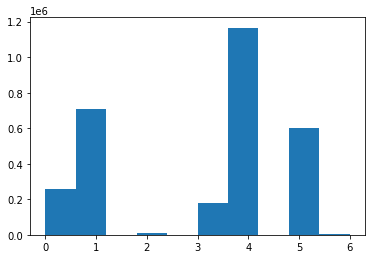

In [ ]:
plt.hist(data['ageRange'])

#### Display plot of AgeRange by User_day_code

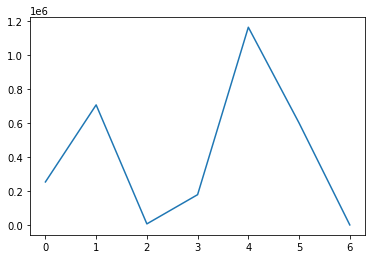

In [ ]:
plt.plot(data.groupby('ageRange')['user_day_code'].count())

**AgeRange:**

0: No se ha podido determinar el rango de edad del usuario

*1: El usuario tiene entre 0 y 16 años*

2: El usuario tiene entre 17 y 18 años

3: El usuario tiene entre 19 y 26 años

*4: El usuario tiene entre 27 y 40 años*

*5: El usuario tiene entre 41 y 65 años*

6: El usuario tiene 66 años o más 


En el Mes de Enero 2018, los usuarios que más utilizando la bici son:

1. El usuario tiene entre 27 y 40 años
2. El usuario tiene entre 17 y 18 años
3. El usuario tiene entre 41 y 65 años

### Desenganche de bici por edad

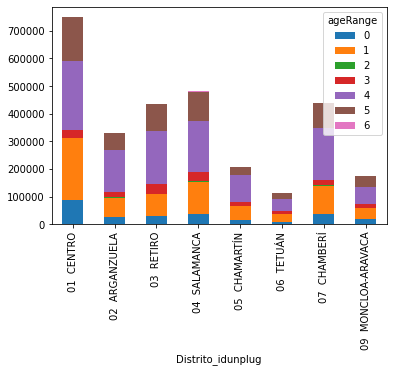

In [ ]:
data.groupby(['Distrito_idunplug', 'ageRange']).size().unstack().plot(kind='bar', stacked=True)

### Enganche de Bici por Edad

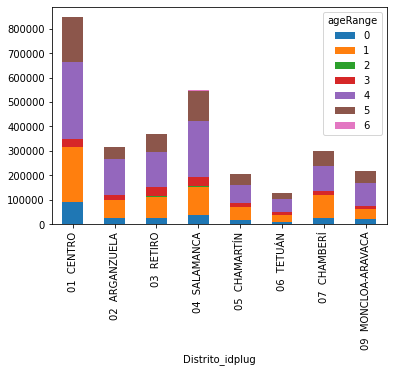

In [ ]:
data.groupby(['Distrito_idplug','ageRange']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

<Figure size 720x360 with 0 Axes>

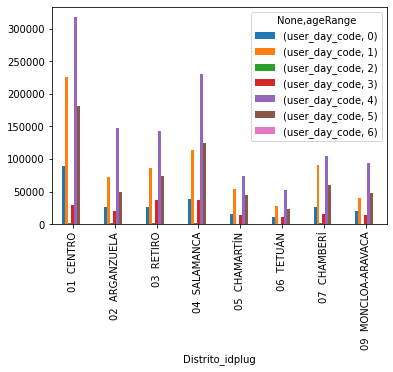

In [ ]:
indpl_age = data.groupby(['Distrito_idplug', 'ageRange']).agg({'user_day_code': 'count'})
fig2 = plt.figure()
fig2.set_figheight(5)
fig2.set_figwidth(10)
indpl_age.unstack().plot.bar()

### En que Distrito desengancha y en cual se engancha



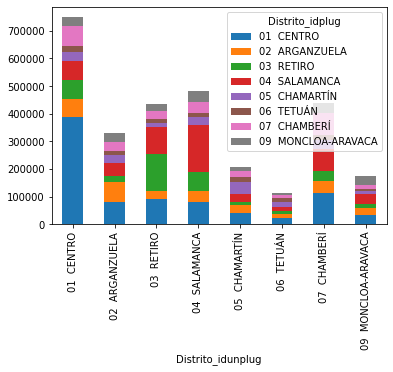

<Figure size 10800x1800 with 0 Axes>

In [ ]:
data.groupby(['Distrito_idunplug', 'Distrito_idplug']).size().unstack().plot(kind='bar', stacked=True)
fig3 = plt.figure()
fig3.set_figheight(25)
fig3.set_figwidth(150)
plt.show()

In [ ]:
dese_eng = pd.DataFrame(data.groupby(['Distrito_idunplug', 'Distrito_idplug']).size())
dese_eng

0
Distrito_idunplug   Distrito_idplug            
01  CENTRO          01  CENTRO           386583
                    02  ARGANZUELA        65985
                    03  RETIRO            67967
                    04  SALAMANCA         71393
                    05  CHAMARTÍN         30474
...                                         ...
09  MONCLOA-ARAVACA 04  SALAMANCA         34915
                    05  CHAMARTÍN         10362
                    06  TETUÁN             7396
                    07  CHAMBERÍ          15167
                    09  MONCLOA-ARAVACA   32407

[64 rows x 1 columns]

### Enero 19

In [ ]:
data19.groupby(['Distrito_idunplug', 'Distrito_idplug']).size().unstack().plot(kind='bar', stacked=True)
fig3 = plt.figure()
fig3.set_figheight(25)
fig3.set_figwidth(150)
plt.show()

NameError: ignored

In [ ]:
dese_eng19 = pd.DataFrame(data19.groupby(['Distrito_idunplug', 'Distrito_idplug']).size())
dese_eng19

###Manipulating data with time variable

In [50]:
data['travel_minutes'] = data['travel_time'] / 60
data['travel_minutes']

0           4.733333
1          13.733333
2          13.733333
3           5.616667
4           5.616667
             ...    
2926624     5.216667
2926625     3.750000
2926626    11.400000
2926627     2.683333
2926628     2.900000
Name: travel_minutes, Length: 2926629, dtype: float64

In [ ]:
data['travel_minutes'].describe()

count    2.926629e+06
mean     2.963612e+01
std      2.524467e+02
min      1.666667e-02
25%      1.666667e-01
50%      9.933333e+00
75%      3.196667e+01
max      2.752708e+04
Name: travel_minutes, dtype: float64

#### Statistcs of User type by travel minutes.

In [ ]:
data.groupby('user_type')['travel_minutes'].describe()

,count,mean,std,min,25%,50%,75%,max
user_type,,,,,,,,
1,534546.0,15.790231,20.775760,0.066667,7.233333,10.750000,16.066667,359.716667
2,6324.0,36.316543,36.901316,1.083333,12.716667,22.858333,48.633333,327.383333
3,2385759.0,32.720677,279.328389,0.016667,0.150000,6.216667,36.833333,27527.083333


#### Grouping by possible type of trip

In [ ]:
travel_35 = data[(data['travel_minutes'] >= 15) & (data['travel_minutes'] <= 35)] # Funtional
travel_180 = data[(data['travel_minutes'] >= 35) & (data['travel_minutes'] <= 180)] # Recreative
travel_190 = data[data['travel_minutes'] >=181] # BreakDown

#### Travel Minutes Plotting

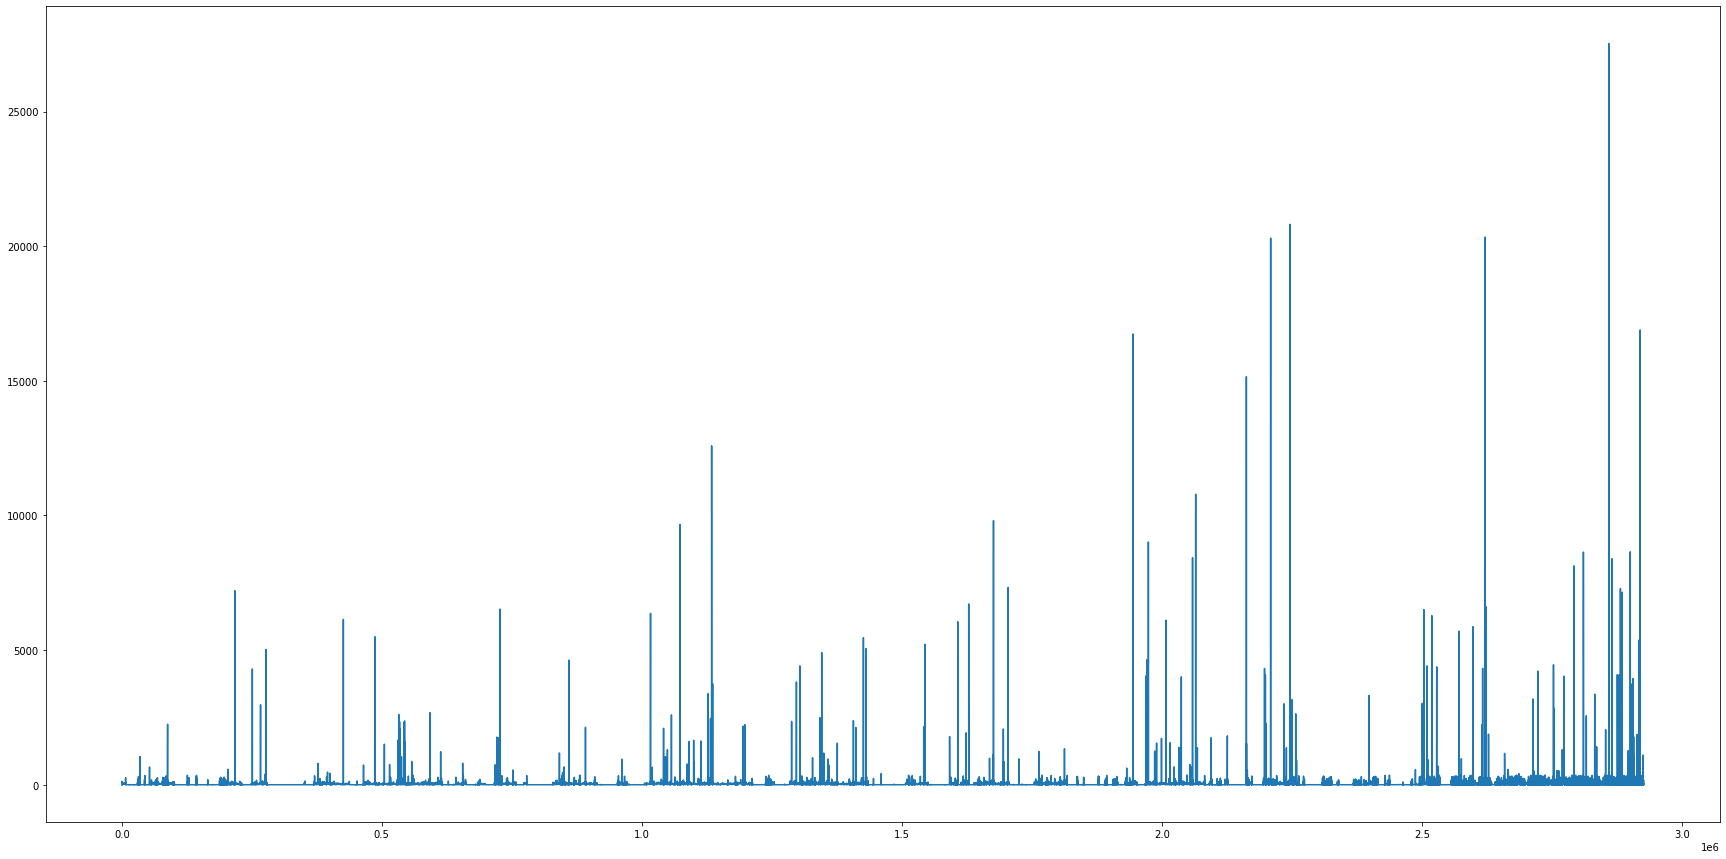

In [ ]:
 data['travel_minutes'].plot(figsize=(30, 15))

### Trip of a specific user

In [ ]:
data['user_day_code'][0]

'b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64644821b72d560b100f'

In [ ]:
data[data['user_day_code'] == 'b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64644821b72d560b100f']

,_id,user_day_code,idunplug_station,Distrito_idunplug,Barrio_idunplug,Longitud_idunplug,Latitud_idunplug,idplug_station,Distrito_idplug,Barrio_idplug,Longitud_idplug,Latitud_idplug,user_type,travel_time,unplug_hourTime,ageRange,zip_code,travel_minutes
0,5a505acd2f384319304ed614,b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64...,6,01 CENTRO,01-04 JUSTICIA,-3.698409,40.424163,7,01 CENTRO,01-04 JUSTICIA,-3.69774,40.425216,1,284,{'$date': '2018-01-01T00:00:00.000+0100'},5,28010,4.733333


In [ ]:
data['idunplug_station'].sort_values().count()

2926629

In [ ]:
# aa = jan18[(jan18.idunplug_station == '1') & (jan18.idplug_station == '2')].index() #don't work

#### Display the tweenty user that most use the bike in January 18 month.

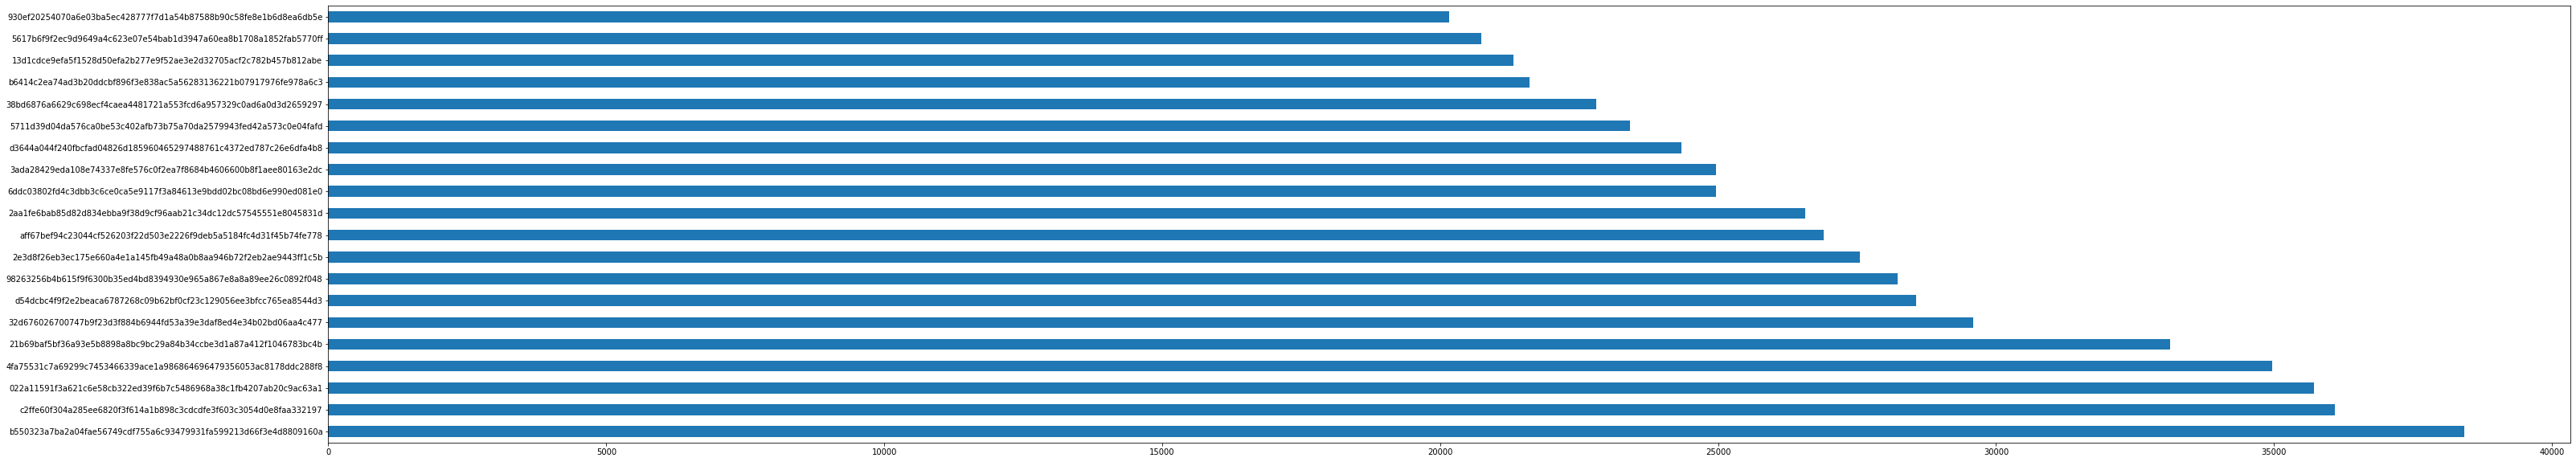

In [ ]:
mostfreque_user = data['user_day_code'].value_counts(sort=True).head(20)

fig = plt.figure(figsize=(50,10))
mostfreque_user.plot.barh()


In [ ]:
data['user_day_code'].value_counts(sort=True).head(1000)

b550323a7ba2a04fae56749cdf755a6c93479931fa599213d66f3e4d8809160a    38416
c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197    36100
022a11591f3a621c6e58cb322ed39f6b7c5486968a38c1fb4207ab20c9ac63a1    35721
4fa75531c7a69299c7453466339ace1a986864696479356053ac8178ddc288f8    34969
21b69baf5bf36a93e5b8898a8bc9bc29a84b34ccbe3d1a87a412f1046783bc4b    33124
                                                                    ...  
a4e08dffb1c341f2883df24efa8b4fd8ec26690cd5ed33bb8113ee49c0516964       36
fadb0427c4e6405039a34f34dc874cf262c5868771efc6b93ebcb11a4d8952b0       36
45f18d971c0c6826547869bb6b65d592851e22b6b274b0537af0b06315b30333       36
2a0d780ff05f6f74192688b2ad0ab475c04456aa0e3b270f6bfa0429cc6fe4d0       36
3166709bec75d49545a155a28499546877b07e20c3fc3ab6ae28b2db7c1b1f7d       36
Name: user_day_code, Length: 1000, dtype: int64

In [ ]:
data[data['user_day_code'] == 'c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197'] #example one person all his travel

,_id,user_day_code,idunplug_station,Distrito_idunplug,Barrio_idunplug,Longitud_idunplug,Latitud_idunplug,idplug_station,Distrito_idplug,Barrio_idplug,Longitud_idplug,Latitud_idplug,user_type,travel_time,unplug_hourTime,ageRange,zip_code,travel_minutes
314362,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
314363,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
314364,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
314365,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
314366,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350457,5a569d872f384338109b97a9,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1,,0.166667
350458,5a569d872f384338109b97a9,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1,,0.166667
350459,5a569d872f384338109b97a9,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1,,0.166667
350460,5a569d872f384338109b97a9,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1,,0.166667


In [ ]:
station = pd.DataFrame(data['idunplug_station'], data['idplug_station']) #create a new dataframe

In [ ]:
data['idunplug_station'].value_counts

<bound method IndexOpsMixin.value_counts of 0            6
1            6
2            6
3          104
4          104
          ... 
2926624     29
2926625     29
2926626     29
2926627     29
2926628     29
Name: idunplug_station, Length: 2926629, dtype: int64>

In [ ]:
data['idunplug_station'].value_counts() # count values of idunplug_station 

128    67652
129    66468
135    66081
132    56105
43     51662
       ...  
173     6358
123     6164
5       5981
124     5838
29      3138
Name: idunplug_station, Length: 166, dtype: int64

In [ ]:
data['idunplug_station'].value_counts(normalize=True, sort=True) #relative frequence

128    0.023116
129    0.022711
135    0.022579
132    0.019171
43     0.017652
         ...   
173    0.002172
123    0.002106
5      0.002044
124    0.001995
29     0.001072
Name: idunplug_station, Length: 166, dtype: float64

In [ ]:
# Know the set in idunplug_station 
# set(jan18['idunplug_station'])

### Rank for user day variable

In [ ]:
user_rank = data['user_day_code'].value_counts()
user_rank

b550323a7ba2a04fae56749cdf755a6c93479931fa599213d66f3e4d8809160a    38416
c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197    36100
022a11591f3a621c6e58cb322ed39f6b7c5486968a38c1fb4207ab20c9ac63a1    35721
4fa75531c7a69299c7453466339ace1a986864696479356053ac8178ddc288f8    34969
21b69baf5bf36a93e5b8898a8bc9bc29a84b34ccbe3d1a87a412f1046783bc4b    33124
                                                                    ...  
9c18c1fc97888f427f612bbd6bdda2cadb4478e782181cf0e12b6ed177a78af6        1
9c14f1bf60e91df7003c40880a1c868e15b0869c1cab2514855a8de4bc818774        1
451bcb72a7622c997619ed83f3fde217eaf979a33b52c5e8f79a7b2477185941        1
a5d75d14e963a2ae2655fbaf801e371e80764ff138d48365dd5e50284fb1e124        1
2bf44a01510a4542d747da8c56bd32d3910e6001d0de148037f4a0ee2b371ac6        1
Name: user_day_code, Length: 140719, dtype: int64

In [ ]:
# Function per userday 
def userday(x):
  return data[data['user_day_code'] == x][['idunplug_station', 'idplug_station',
       'user_type','travel_time','unplug_hourTime', 'ageRange']]

In [ ]:
userday('c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197')

,idunplug_station,idplug_station,user_type,travel_time,unplug_hourTime,ageRange
314362,82,82,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1
314363,82,82,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1
314364,82,82,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1
314365,82,82,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1
314366,82,82,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1
...,...,...,...,...,...,...
350457,88,88,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1
350458,88,88,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1
350459,88,88,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1
350460,88,88,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1


In [ ]:
data.loc[data['user_day_code'] == 'c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197']

,_id,user_day_code,idunplug_station,Distrito_idunplug,Barrio_idunplug,Longitud_idunplug,Latitud_idunplug,idplug_station,Distrito_idplug,Barrio_idplug,Longitud_idplug,Latitud_idplug,user_type,travel_time,unplug_hourTime,ageRange,zip_code,travel_minutes
314362,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
314363,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
314364,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
314365,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
314366,5a569d852f384338109b9644,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,82,03 RETIRO,03-05 JERÓNIMOS,-3.676577,40.411760,3,38,{'$date': '2018-01-06T16:00:00.000+0100'},1,,0.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350457,5a569d872f384338109b97a9,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1,,0.166667
350458,5a569d872f384338109b97a9,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1,,0.166667
350459,5a569d872f384338109b97a9,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1,,0.166667
350460,5a569d872f384338109b97a9,c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603...,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,88,04 SALAMANCA,04-06 CASTELLANA,-3.683747,40.431208,3,10,{'$date': '2018-01-06T19:00:00.000+0100'},1,,0.166667


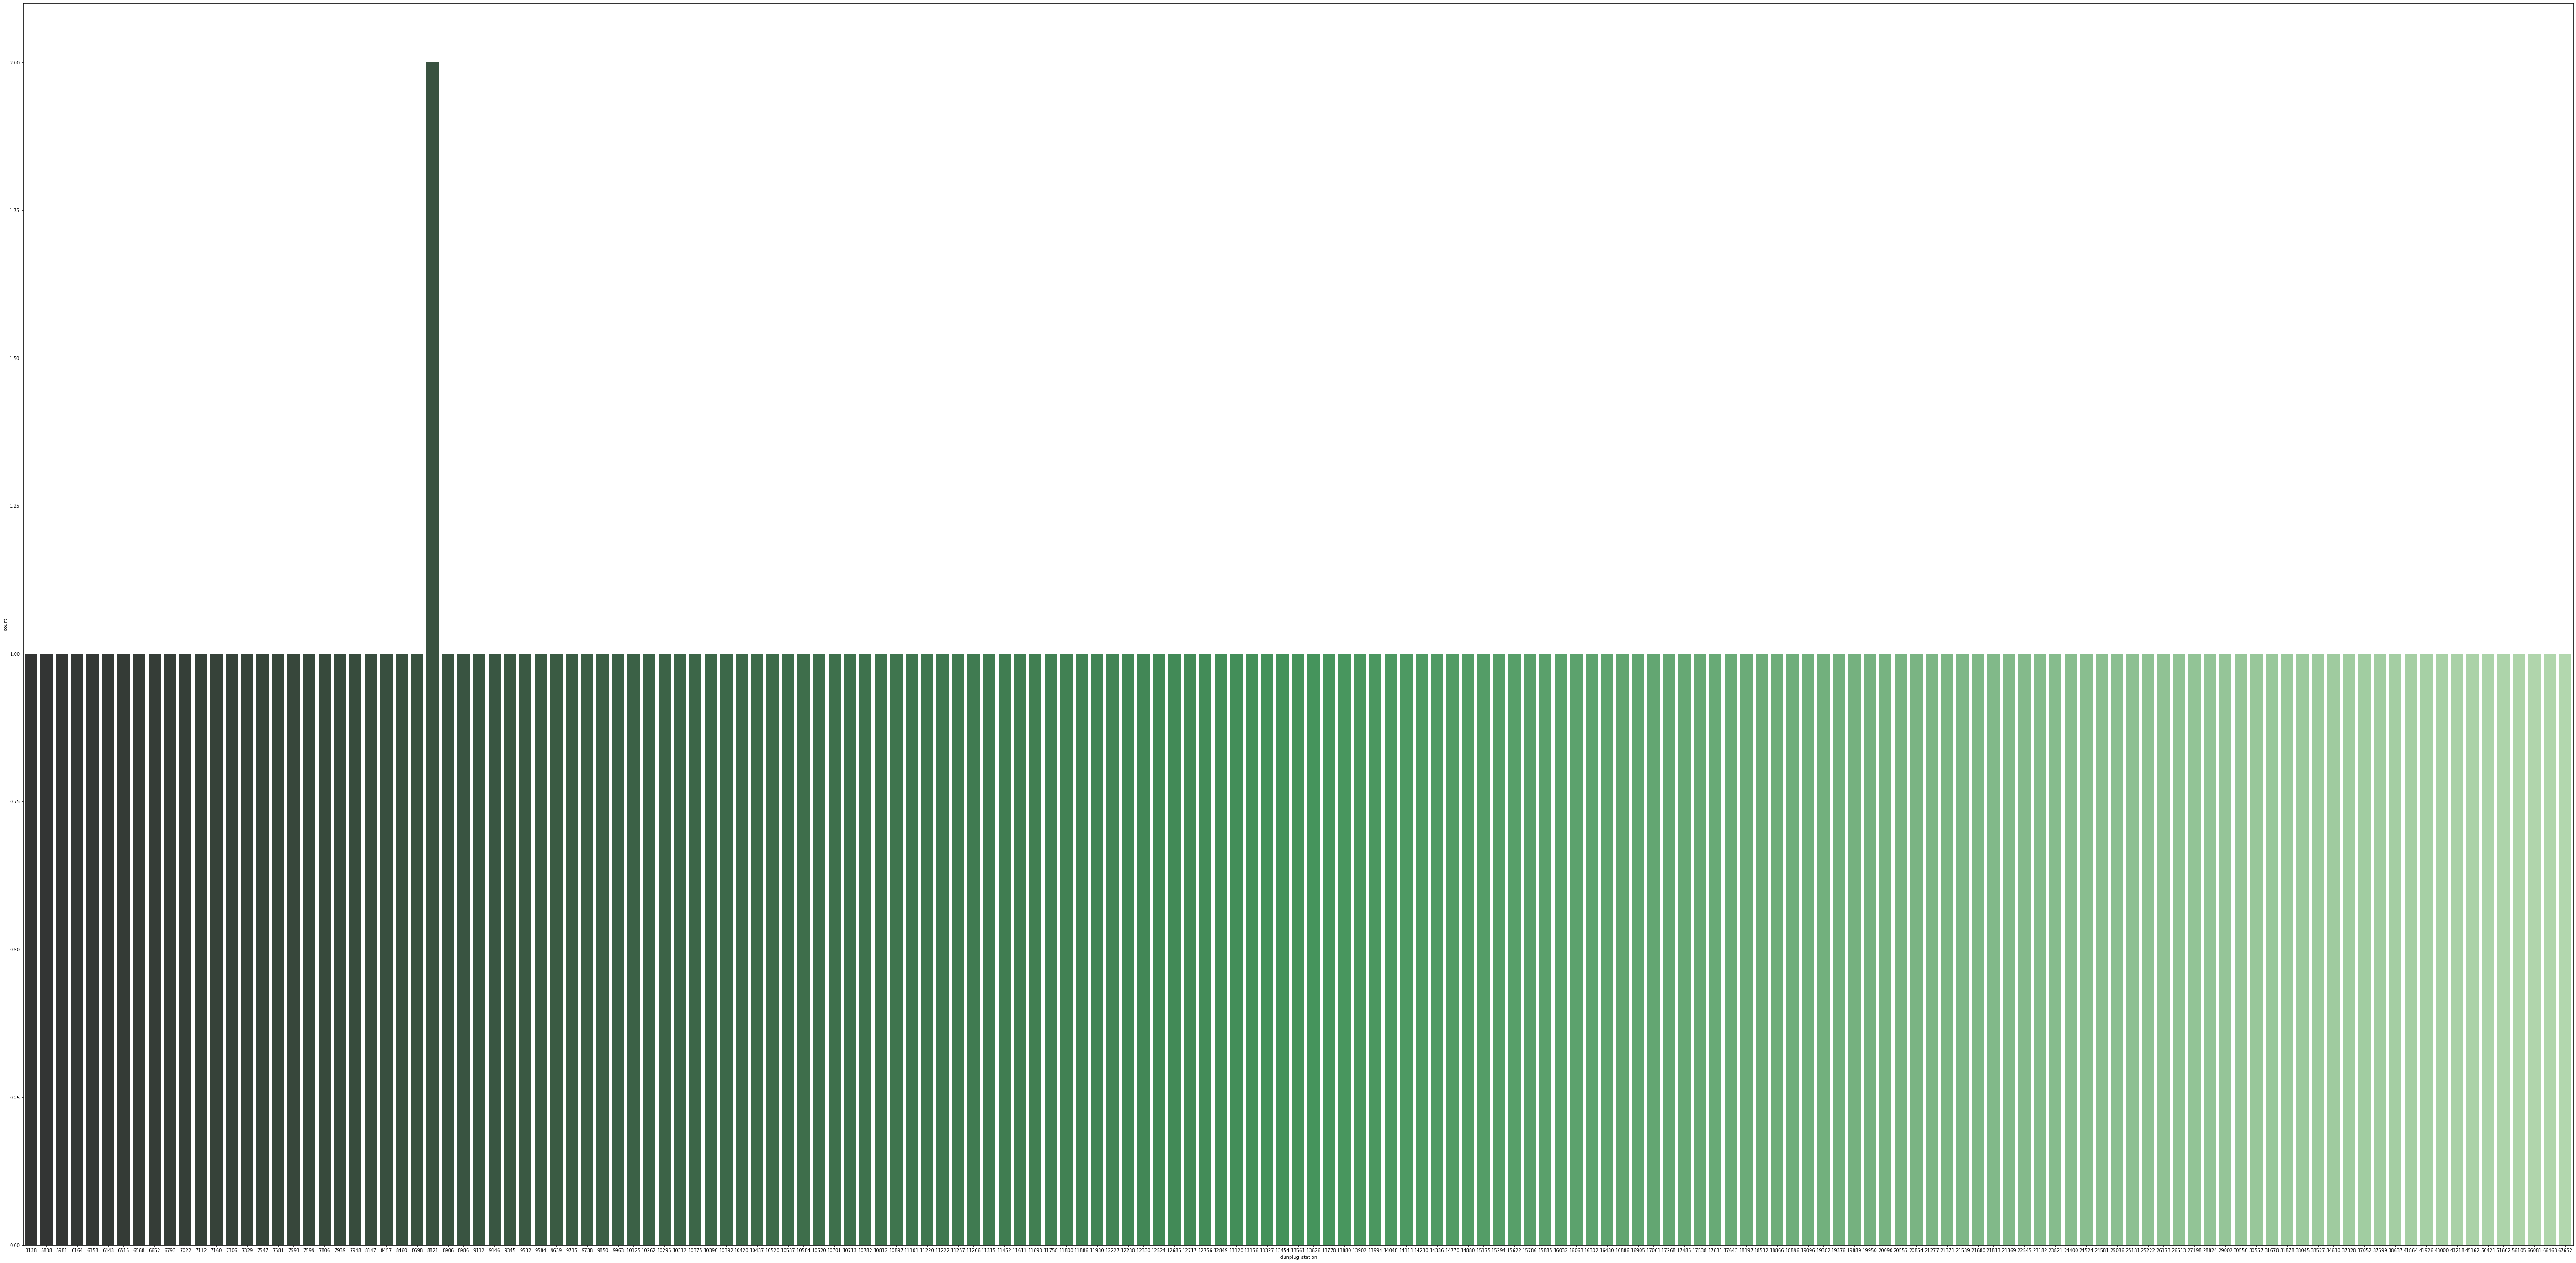

In [ ]:
fig = plt.figure(figsize=(100,50))
sns.countplot(x=data["idunplug_station"].value_counts(sort=True), data=data, hue_order=True, palette="Greens_d")


#### The most used stations for users

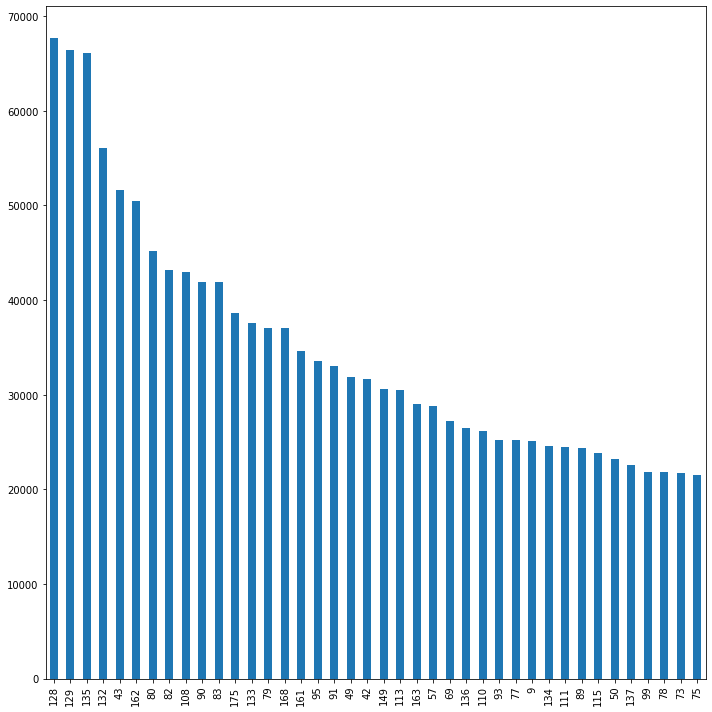

In [ ]:
# values_num_station = jan18["idunplug_station"].value_counts(sort=True).head(100)
most_stations = data["idunplug_station"].value_counts(sort=True).head(40)
fig = plt.figure(figsize=(10,10))
most_stations.plot(kind='bar')
plt.tight_layout()

In [ ]:
data["idunplug_station"].value_counts(sort=True)

128    67652
129    66468
135    66081
132    56105
43     51662
       ...  
173     6358
123     6164
5       5981
124     5838
29      3138
Name: idunplug_station, Length: 166, dtype: int64

In [ ]:
# fig, ax = plt.hist()
# y = jan18["idunplug_station"].value_counts(sort=True).head(3)
# x = ["129", "43", "57"]
# n = ax.hist(x, density=1)
# ax.hist(x, y)
# ax.set_xlabel('number station')
# ax.set_ylabel('frequence')
# ax.set_title(r'Testing')
# # Tweak spacing to prevent clipping of ylabel
# plt.show()

In [ ]:
# fig = plt.figure(figsize=(50,50))
# sns.countplot(x=jan18["idunplug_station"].value_counts(sort=True).head(5), data=jan18, palette="Greens_d")

In [ ]:
# aa=jan18[['idunplug_base']].rank()
# plt.hist(aa, bins = 8)

(array([1., 0., 0., 0., 0., 0., 0., 2., 3., 4., 3., 3., 4., 3., 2., 5., 3.,
        5., 3., 8., 8., 4., 5., 5., 3., 3., 2., 4., 3., 5., 2., 2., 2., 1.,
        3., 2., 1., 3., 2., 3., 1., 1., 2., 2., 1., 3., 0., 1., 1., 3., 3.,
        0., 1., 0., 1., 0., 1., 1., 2., 3., 0., 0., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1.]),
 array([ 3138.        ,  3506.65142857,  3875.30285714,  4243.95428571,
         4612.60571429,  4981.25714286,  5349.90857143,  5718.56      ,
         6087.21142857,  6455.86285714,  6824.51428571,  7193.1657

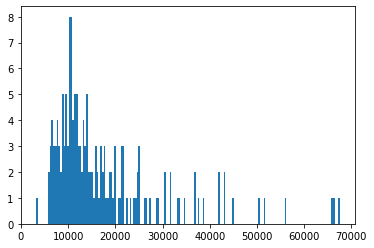

In [ ]:
plt.hist(data['idunplug_station'].value_counts(), bins=175)

In [ ]:
# cuelgan = jan18[   (jan18.idplug_station == 85)
#                   |(jan18.idplug_station == 74)
#                   |(jan18.idplug_station == 69)
#                   |(jan18.idplug_station == 65)
#                   |(jan18.idplug_station == 60)
#                   |(jan18.idplug_station == 79)
#                   |(jan18.idplug_station == 77)
#                   |(jan18.idplug_station == 76)
#                   |(jan18.idplug_station == 71)
#                   |(jan18.idplug_station == 68)
#                   |(jan18.idplug_station == 63)]

# #Gráfico
# import seaborn as sns
# import matplotlib.pyplot as plt
# graph = cuelgan['idunplug_station'].value_counts(normalize=True, sort=True)
# plt.figure(figsize=(50,10))
# sns.barplot(graph.index, graph.values, alpha=1)
# plt.xlabel('Estaciones donde van', fontsize=12)
# plt.ylabel('% de frecuencia', fontsize=12)
# plt.show()

# # Numero de usurios que llegan por estación, ordenado de mayor a menor
# cuelgan['idplug_station'].value_counts(sort=True).head()

### Type of user

* 0: Could not determine user type
* 1: Annual user (holder of an annual pass)
* 2: Occasional user
* 3: Company worker




In [ ]:
data['user_type'].value_counts()

In [ ]:
data['user_type'].describe()

### Zip Code

In [65]:
# DATA CLEANING ZIP CODE
import re
data['zip_code'].unique()
df_1 = data[data.zip_code.astype(str).str.contains(re.compile('\d{5}'))] #CLEANING THE DATA ZIP CODE
df_1.shape

(768832, 22)

In [ ]:
## ZIP CODE 

# jan18['zip_code'].replace('^(?!^(?:0[1-9]|[1-4]\d|5[0-2])\d{3}$).*', np.nan, regex=True, inplace=True) #transform empty data
# len(jan18[-jan18['zip_code'].duplicated(keep=False)]) #count the data
# jan18['zip_code'].value_counts()
# # User by postal code withouth clean
# jan18.groupby(['zip_code'])['id'].count()

# # Function to clean of postal code 1/3
# def make_int(s):
#     s = s.strip()
#     return int(s) if (s and s.isdigit()) else 0

#     # Function to clean of postal code 2/3
# jan18['zip_code_as_int'] = jan18['zip_code'].apply(lambda x: make_int(x))

# # Function to clean of postal code 3/3
# zip_id = jan18.groupby(['zip_code_as_int'])['id'].count()

In [ ]:
# plt.scatter(top_idunp, top_idp)

### Distance Calculate using Haversine

In [63]:
#Calculate KMs 
from numpy import cos, sin, arcsin, sqrt
from math import radians

def haversine(data):
  lon1 = data['Longitud_idunplug']
  lat1 = data['Latitud_idunplug']
  lon2 = data['Longitud_idplug']
  lat2 = data['Latitud_idplug']
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) #change a radians
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * arcsin(sqrt(a))
  km = 6367 * c # Tierra es una esfera perfecta de radio RT = 6367
  return km 
# data['distance'] = data.apply(lambda data: haversine(data), axis=1

In [64]:
data['distance'] = data.apply(lambda data: haversine(data), axis=1)

In [ ]:
data['distance'].describe()

La distancia media que realiza los viajeros es de 2 km.

In [ ]:
plt.hist(data.distance, alpha =0.5)

### Slope Calculate 


In [ ]:
lon1 = data['Longitud_idunplug']
lat1 = data['Latitud_idunplug']
lon2 = data['Longitud_idplug']
lat2 = data['Latitud_idplug']
m = ""
slope = ""

if slope == 0:
  m = 0
else: 
  lat_dif = lat2-lat1
  lon_dif = lon2-lon1
  m = (lat_dif/lon_dif) * 100
data['slope'] = m

In [ ]:
data.head(5)

In [ ]:
fig1 = plt.figure(1)
fig1.set_figheight(5)
fig1.set_figwidth(10)
plt.title("Scatter plot Slope and Distance")
plt.scatter(data['slope'], data['distance'])
fig2 = plt.figure(2)
fig2.set_figheight(5)
fig2.set_figwidth(10)
plt.title("Scatter plot Slope and Travel Minutes")
plt.scatter(data['slope'], data['travel_time'])
plt.show()

In [ ]:
plt.bar(data['slope'], data['user_type'])

In [ ]:
# exa=data['slope'].head(100000)
# dist_=data['distance'].head(100000)

In [ ]:
# fig4 = plt.figure()
# fig4.set_figheight(20)
# fig4.set_figwidth(15)
# plt.stem(exa)
# plt.show()

In [ ]:
# markerline, stemlines, baseline = plt.stem(
#    exa, linefmt='grey', markerfmt='D', bottom=1.1)
# markerline.set_markerfacecolor('none')
# plt.show()

In [ ]:
# fig4 = plt.figure()
# fig4.set_figheight(20)
# fig4.set_figwidth(40)
# plt.stem(exa,dist_)
# plt.show()

In [ ]:

# lon1 = data['Longitud_idunplug']
# lat1 = data['Latitud_idunplug']
# lon2 = data['Longitud_idplug']
# lat2 = data['Latitud_idplug']
# lat_dif = lat2-lat1
# lon_dif = lon2-lon1
# m = ""

In [ ]:
# if lon_dif == 0:
#   m = 0
# else:
#   m = (lat_dif/lon_dif) * 100

In [ ]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# import pandas
# stations_2019 = pandas.read_csv("stations_2019.csv")
result = pd.DataFrame()


# DATOS INTRODUCIDOS POR EL USUARIO
def get_source():
    return input(f"\n Indica el número de la estación donde te encuentras. \n"
                 f"Este numero debe estar comprendido entre  min: {min} y max: {max}: ")


def get_destination():
    return input(f'\n Indica el número de la estación donde vas. \n'
                 f'Este numero debe estar comprendido entre  min: {min} y max: {max}: ')


# PROCESO DE VALIDACION - NO ES NECESARIO PERO PARA QUE PRACTIQUES
min = sorted(pd.unique(stations_2019['ids']))[0]
max = sorted(pd.unique(stations_2019['ids']))[-1]


def validation_input(i, _min, _max):
    return True if (i and _max > input > _min and isinstance(i, float)) else False


# OBTENCION DE LA LATITUD Y LONGITUD
def get_latitude_and_longitude_by_input(type, r):
    # para ver si el df es vacio o no
    while r.empty:
        # devulevo la entrada source si type == 'source' sino devulevo destination
        i = get_source() if type == 'source' else get_destination()
        # localiza en la columna ids del df stations_2019 si existe algun valor igual a i
        # si existe te devuleve su lati y longi y sino te devuelve un df vacio
        r = stations_2019.loc[stations_2019['ids'].astype(str) == i, ['LATITUD', 'LONGITUD']]
    la_s = r['LATITUD'].values[0]
    lo_s = r['LONGITUD'].values[0]
    return la_s, lo_s


# CALCULO DE LA PENDIENTE
def print_slope(latitud_d, latitud_s, longitude_d, longitude_s):
    dif_lon = longitude_d - longitude_s
    if dif_lon == 0:
        print("\n No hay pendiente")
    else:
        slope = (latitud_d - latitud_s) / (longitude_d - longitude_s) * 100
        print(f"\n La pendiente es: {slope}")


latitud_s, longitude_s = get_latitude_and_longitude_by_input('source', result)
latitud_d, longitude_d = get_latitude_and_longitude_by_input('destination', result)

# print(f"\nPara el origen hemos encontrado los siguientes datos: LONGITUD:{latitud_s} - LATITUD:{longitude_s} ")
# print(f"\nPara el origen hemos encontrado los siguientes datos: LONGITUD:{latitud_d} - LATITUD:{longitude_d} ")

print_slope(latitud_d, latitud_s, longitude_d, longitude_s)

In [ ]:
m

In [ ]:
# import matplotlib.pyplot as plt
# fig=plt.figure()
# fig.set_figheight(10)
# fig.set_figwidth(25)

# plt.bar(data['distance'], data['slope'], align='center', alpha=0.5, width=0.8, color = 'gray')

# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# fig=plt.figure()
# fig.set_figheight(10)
# fig.set_figwidth(25)

# plt.scatter(data['distance'], data['slope'], align='center', alpha=0.5, width=0.8, color = 'gray')

# plt.show()

In [ ]:
data['slope'].describe()

In [ ]:
idunplug_station = data['idplug_station'].sort_values().unique()
idunplug_station

In [ ]:
data.head(3)

#### Este no funciona

In [ ]:
origen = int(input("Indica el nº de la estación donde te encuentras: ")) #ask where is your positions
# destino = int(input("Indica el nº de la estación a la que vas: "))
idunplug_station = data['idplug_station'].sort_values().unique() # search value in idunplug_station
# idplug_station = data['idplug_station'].sort_values().unique()
 
lon1 = data['Longitud_idunplug'].sort_values().unique()
lat1 = data['Latitud_idunplug']
 
 
# lon2 = data['Longitud_idplug']
# lat2 = data['Latitud_idplug']
 
# lat_dif = lat2-lat1
# lat_dif
# lon_dif = lon2-lon1
# lon_dif
# m = lat_dif/lon_dif
# m = m*100
 
# def calculating_slope(origen, destino):
result1 = ""
# result2 = ""
 
for i in idunplug_station:
    if i == origen:
          result1 = result1
#     else:
#       print("No disponemos de esa estación")
 
      # for j in idplug_station:
      #   if j == destino:
      #       result2 = lon2[destino], lat2[destino]
 
# lat_dif = result2[1] - result1[1]
# lon_dif = result2[0] - result1[0]
# m = lat_dif/lon_dif
# m = m * 100
 
 
        # else:
          # print("No disponemos de esa estación")

In [ ]:
df.columns

#### Este funciona pero no entra bien el bucle

In [ ]:
result_origen= ""
# result_destino = ""
origen = int(input("Indica el nº de la estación donde te encuentras: "))
# destino = int(input("Indica el nº de la estación a donde vas: "))
for i, row in stations_2019.iterrows(): #tomo como referencia el dataframe de estaciones 2019 para obtener latitud y longitud
    if i == origen:
      result_origen = row[10], row[11]
      break 
    else: 
      print("No se encuentra el estacionamiento")
# print(result_origen)

# for j, row in stations_2019.iterrows():   
#       if j == destino:
#         result_destino = row[10], row[11]

# lat_dif = result_destino[1] - result_origen[1]
# lon_dif = result_destino[0] - result_origen[0]
# m = lat_dif/lon_dif
# m = m * 100

print(result_origen)
# print(result_destino)

In [ ]:
stations_2019.head()

In [ ]:
result_origen_lat= ""
result_origen_lon = ""
origen = int(input("Indica el nº de la estación donde te encuentras: "))
# destino = int(input("Indica el nº de la estación a donde vas: ")) 


result_origen_lat, result_origen_lon =  stations_2019.iloc[stations_2019.index == origen, [10, 11]].to_list()

In [ ]:
pru = stations_2019.iloc[stations_2019.index == 65, [10, 11]]
pru.iloc[:, 0]

In [ ]:
pru.head()

In [ ]:
for i, row in stations_2019.iterrows(): 
    if i == origen:
        result_origen = row[10], row[11]
        break
else:
    print("No existe esa estación") 

In [ ]:
stations_2019[stations_2019['ids'] == 65]

In [ ]:
data.head(5)

#### Este no funciona, probando nueva alternativa

In [ ]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# import pandas
# stations_2019 = pandas.read_csv("stations_2019.csv")
result = pandas.DataFrame()


# DATOS INTRODUCIDOS POR EL USUARIO
def get_source():
    return input(f"\n Indica el número de la estación donde te encuentras. \n"
                 f"Este numero debe estar comprendido entre  min: {min} y max: {max}: ")


def get_destination():
    return input(f'\n Indica el número de la estación donde vas. \n'
                 f'Este numero debe estar comprendido entre  min: {min} y max: {max}: ')


# PROCESO DE VALIDACION - NO ES NECESARIO PERO PARA QUE PRACTIQUES
min = sorted(pandas.unique(stations_2019['ids']))[0]
max = sorted(pandas.unique(stations_2019['ids']))[-1]


def validation_input(i, _min, _max):
    return True if (i and _max > input > _min and isinstance(i, float)) else False


# OBTENCION DE LA LATITUD Y LONGITUD
def get_latitude_and_longitude_by_input(type, r):
    # para ver si el df es vacio o no
    while r.empty:
        # devulevo la entrada source si type == 'source' sino devulevo destination
        i = get_source() if type == 'source' else get_destination()
        # localiza en la columna ids del df stations_2019 si existe algun valor igual a i
        # si existe te devuleve su lati y longi y sino te devuelve un df vacio
        r = stations_2019.loc[stations_2019['ids'].astype(str) == i, ['LATITUD', 'LONGITUD']]
    la_s = r['LATITUD'].values[0]
    lo_s = r['LONGITUD'].values[0]
    return la_s, lo_s


# CALCULO DE LA PENDIENTE
def print_slope(latitud_d, latitud_s, longitude_d, longitude_s):
    dif_lon = longitude_d - longitude_s
    if dif_lon == 0:
        print("\n No es posible el calculo de la pendiente")
    else:
        slope = (latitud_d - latitud_s) / (longitude_d - longitude_s) * 100
        print(f"\n La pendiente es: {slope}")


latitud_s, longitude_s = get_latitude_and_longitude_by_input('source', result)
latitud_d, longitude_d = get_latitude_and_longitude_by_input('destination', result)

print(f"\nPara el origen hemos encontrado los siguientes datos: LONGITUD:{latitud_s} - LATITUD:{longitude_s} ")
print(f"\nPara el origen hemos encontrado los siguientes datos: LONGITUD:{latitud_d} - LATITUD:{longitude_d} ")

print_slope(latitud_d, latitud_s, longitude_d, longitude_s)

In [ ]:
data[data['idunplug_station'] == 6]

In [ ]:
data.head(5)

In [ ]:
# lat1[origen]
lon1[0]

In [ ]:
df[df['ids'] == 7]

### Deleting Nan

In [ ]:
data.isnull().sum()

_id                  0
user_day_code        0
idunplug_station     0
Distrito_idunplug    0
Barrio_idunplug      0
Longitud_idunplug    0
Latitud_idunplug     0
idplug_station       0
Distrito_idplug      0
Barrio_idplug        0
Longitud_idplug      0
Latitud_idplug       0
user_type            0
travel_time          0
unplug_hourTime      0
ageRange             0
zip_code             0
travel_minutes       0
distance             0
slope                0
broke                0
count_travel_x       0
count_travel_y       0
_merge               0
dtype: int64

In [ ]:
data = data.dropna()

### Slope Analysis

In [ ]:
hight_slope = data[data['slope'] >= 4139.666066302884]
plt.scatter(hight_slope['travel_minutes'], hight_slope['slope'], alpha=0.0555)

In [ ]:
hight_slope.groupby('user_type').count()#hight_slope(subida, es decir pendiente)

In [ ]:
low_slope.groupby('user_type').count()

In [ ]:
low_slope.head()

In [ ]:
low_slope = data[data['slope'] == -577795.0712825452]
plt.scatter(low_slope['travel_minutes'], low_slope['slope'], alpha=0.0555)

In [ ]:
low_slope.info()

In [ ]:
low_slope[low_slope['user_type']!=3]

In [ ]:
low_slope[low_slope['user_type']==3]

In [ ]:

plt.scatter(data['distance'],data['slope'], alpha=0.0055)

In [ ]:
import seaborn as sns
sns.pointplot(x="distance", y="slope",data=data)

### Broke or not

In [52]:
broke_dict = {3:1, 2:0, 1:0}
data['broke'] = data.user_type.map(broke_dict)

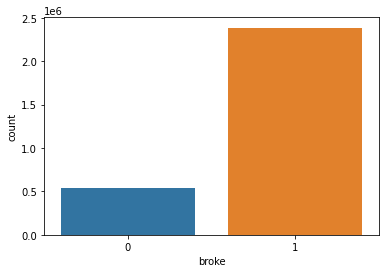

In [53]:
jan18_broke = sns.countplot(x='broke', data=data)

### Travel per user_day_code

In [54]:
data_user = data.groupby('user_day_code').count()
data_user.describe()

,_id,idunplug_station,Distrito_idunplug,Barrio_idunplug,Longitud_idunplug,Latitud_idunplug,idplug_station,Distrito_idplug,Barrio_idplug,Longitud_idplug,Latitud_idplug,user_type,travel_time,unplug_hourTime,ageRange,zip_code,travel_minutes,broke
count,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000,140719.000000
mean,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682,20.797682
std,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082,454.710082
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000,38416.000000


In [56]:
data['count_travel'] = 0
data_user_groupby_count = data[['user_day_code', 'count_travel']].groupby('user_day_code').count()
data_user_groupby_count= data_user_groupby_count.reset_index()
data_user_groupby_count
# data = pd.merge(data, data_user_groupby_count, on="user_day_code", how="left", indicator=True)

,user_day_code,count_travel
0,000049d964247d294a64274532f52cf30aec52d35d3f6e...,1
1,00017e5896aa97dc6eea1186ff153d5945a802f9bbb1f9...,1
2,0001a94af1655cf8f07a711ef61f802c995d9233309af9...,1
3,0001aebede7ee7412931a3f2b5cfd139048610c9788023...,1
4,0001d7326dbe135189999a728480bfe2a0752a86b3ec8d...,9
...,...,...
140714,fffeace3ed193b043935e49911d6a0bbd5c5c1149d96ad...,1
140715,fffeca160c8d97895a6a3fe386f85c3f98d5381742ee78...,4
140716,ffff105c72d94f00144297001b3f6cd0c68671b434ec89...,4
140717,ffff6473059dbb4591c70e0f2a68d1ebeeb44d57158482...,1


In [57]:
data = pd.merge(data, data_user_groupby_count, on="user_day_code", how="left")

In [59]:
data = data.rename(columns={"count_travel_y":"count_travel"})
data = data.drop(['count_travel_x'], axis=1)
data.head()

,_id,user_day_code,idunplug_station,Distrito_idunplug,Barrio_idunplug,Longitud_idunplug,Latitud_idunplug,idplug_station,Distrito_idplug,Barrio_idplug,Longitud_idplug,Latitud_idplug,user_type,travel_time,unplug_hourTime,ageRange,zip_code,travel_minutes,broke,count_travel0,count_travel
0,5a505acd2f384319304ed614,b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64...,6,01 CENTRO,01-04 JUSTICIA,-3.698409,40.424163,7,01 CENTRO,01-04 JUSTICIA,-3.697740,40.425216,1,284,{'$date': '2018-01-01T00:00:00.000+0100'},5,28010,4.733333,0,0,1
1,5a505ad02f384319304ed925,38f477ef63c0d2f1cfcc673e4a5b9054512c51f1756b3f...,6,01 CENTRO,01-04 JUSTICIA,-3.698409,40.424163,65,01 CENTRO,01-03 CORTES,-3.693135,40.410829,1,824,{'$date': '2018-01-01T03:00:00.000+0100'},2,28007,13.733333,0,0,4
2,5a505ad02f384319304ed925,38f477ef63c0d2f1cfcc673e4a5b9054512c51f1756b3f...,6,01 CENTRO,01-04 JUSTICIA,-3.698409,40.424163,65,03 RETIRO,03-05 JERÓNIMOS,-3.689382,40.416695,1,824,{'$date': '2018-01-01T03:00:00.000+0100'},2,28007,13.733333,0,0,4
3,5a505adb2f384319304ee2dd,38f477ef63c0d2f1cfcc673e4a5b9054512c51f1756b3f...,104,04 SALAMANCA,04-01 RECOLETOS,-3.689579,40.426766,67,01 CENTRO,01-03 CORTES,-3.693135,40.410829,1,337,{'$date': '2018-01-01T17:00:00.000+0100'},2,28007,5.616667,0,0,4
4,5a505adb2f384319304ee2dd,38f477ef63c0d2f1cfcc673e4a5b9054512c51f1756b3f...,104,04 SALAMANCA,04-01 RECOLETOS,-3.689579,40.426766,67,03 RETIRO,03-05 JERÓNIMOS,-3.689382,40.416695,1,337,{'$date': '2018-01-01T17:00:00.000+0100'},2,28007,5.616667,0,0,4


### Correlation of data

In [ ]:
data.corr()

,idunplug_station,Longitud_idunplug,Latitud_idunplug,idplug_station,Longitud_idplug,Latitud_idplug,user_type,travel_time,ageRange,travel_minutes,distance,slope,broke,count_travel,count_travel
idunplug_station,1.000000,-0.002652,0.297391,0.467395,0.042190,0.110246,0.093171,0.012230,0.065333,0.012230,0.310063,-0.003915,0.093810,-0.038086,NaN
Longitud_idunplug,-0.002652,1.000000,-0.014378,0.086307,0.093294,0.001842,0.065378,-0.004194,0.045498,-0.004194,0.009982,-0.004487,0.065547,0.049585,NaN
Latitud_idunplug,0.297391,-0.014378,1.000000,0.138400,-0.004831,0.085875,0.030247,0.000735,-0.008695,0.000735,0.085081,0.010395,0.030433,-0.012194,NaN
idplug_station,0.467395,0.086307,0.138400,1.000000,0.049934,0.149045,0.038654,0.016050,0.009082,0.016050,0.218839,0.000495,0.039252,-0.021456,NaN
Longitud_idplug,0.042190,0.093294,-0.004831,0.049934,1.000000,0.046533,0.045895,0.005086,0.011698,0.005086,-0.015236,-0.005180,0.046057,0.069918,NaN
Latitud_idplug,0.110246,0.001842,0.085875,0.149045,0.046533,1.000000,0.025062,0.006829,0.007413,0.006829,0.099999,0.004599,0.025208,-0.010437,NaN
user_type,0.093171,0.065378,0.030247,0.038654,0.045895,0.025062,1.000000,0.025989,0.075628,0.025989,0.035312,-0.008348,0.998260,0.440699,NaN
travel_time,0.012230,-0.004194,0.000735,0.016050,0.005086,0.006829,0.025989,1.000000,0.030060,1.000000,0.018563,0.001176,0.025844,-0.056180,NaN
ageRange,0.065333,0.045498,-0.008695,0.009082,0.011698,0.007413,0.075628,0.030060,1.000000,0.030060,0.038409,0.010730,0.079801,-0.212110,NaN
travel_minutes,0.012230,-0.004194,0.000735,0.016050,0.005086,0.006829,0.025989,1.000000,0.030060,1.000000,0.018563,0.001176,0.025844,-0.056180,NaN


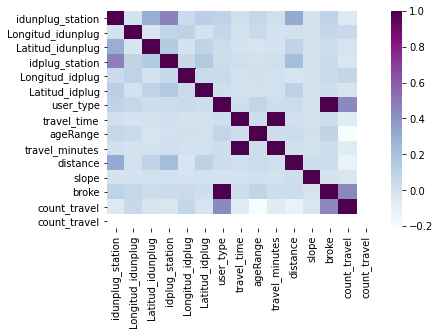

In [ ]:
sns.heatmap(data.corr(), cmap="BuPu", linewidths=0.0001)

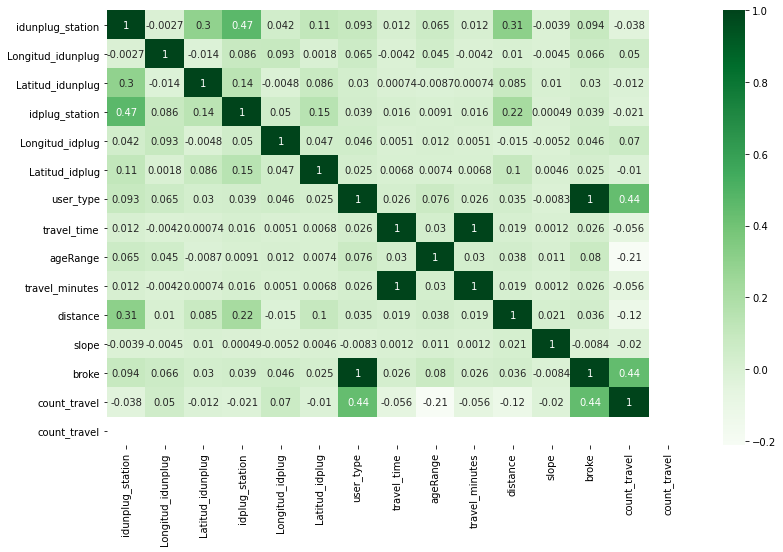

In [ ]:
plt.figure(figsize=(13, 8))
sns.heatmap(data.corr(), annot=True, cmap="Greens")

Hay correlación entre desenganche de la bicicleta con la variable enganche de 0.48. 

El tipo de usuario tiene correlación el total de viaje de 0.46. 

El rompense una bici tiene relación el total de vaije de 0.46.

In [ ]:
vbles = data.loc[:,['user_type', 'count_travel','travel_time', 'distance', 'slope', 'ageRange', 'zip_code']]
vbles.corr()

,user_type,count_travel,count_travel,travel_time,distance,slope,ageRange
user_type,1.000000,0.440699,NaN,0.025989,0.035312,-0.008348,0.075628
count_travel,0.440699,1.000000,NaN,-0.056180,-0.115030,-0.019945,-0.212110
count_travel,NaN,NaN,NaN,NaN,NaN,NaN,NaN
travel_time,0.025989,-0.056180,NaN,1.000000,0.018563,0.001176,0.030060
distance,0.035312,-0.115030,NaN,0.018563,1.000000,0.021183,0.038409
slope,-0.008348,-0.019945,NaN,0.001176,0.021183,1.000000,0.010730
ageRange,0.075628,-0.212110,NaN,0.030060,0.038409,0.010730,1.000000


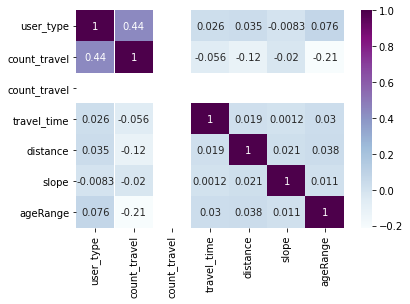

In [ ]:
sns.heatmap(vbles.corr(), cmap = "BuPu", annot= True, linewidths=0.0001)

In [ ]:
# sns.pairplot(jan18, x_vars=user_day_code, y_vars=idplugbase)

In [ ]:
%%time
# plt.scatter(userdaycode, idplugbase)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.54 µs


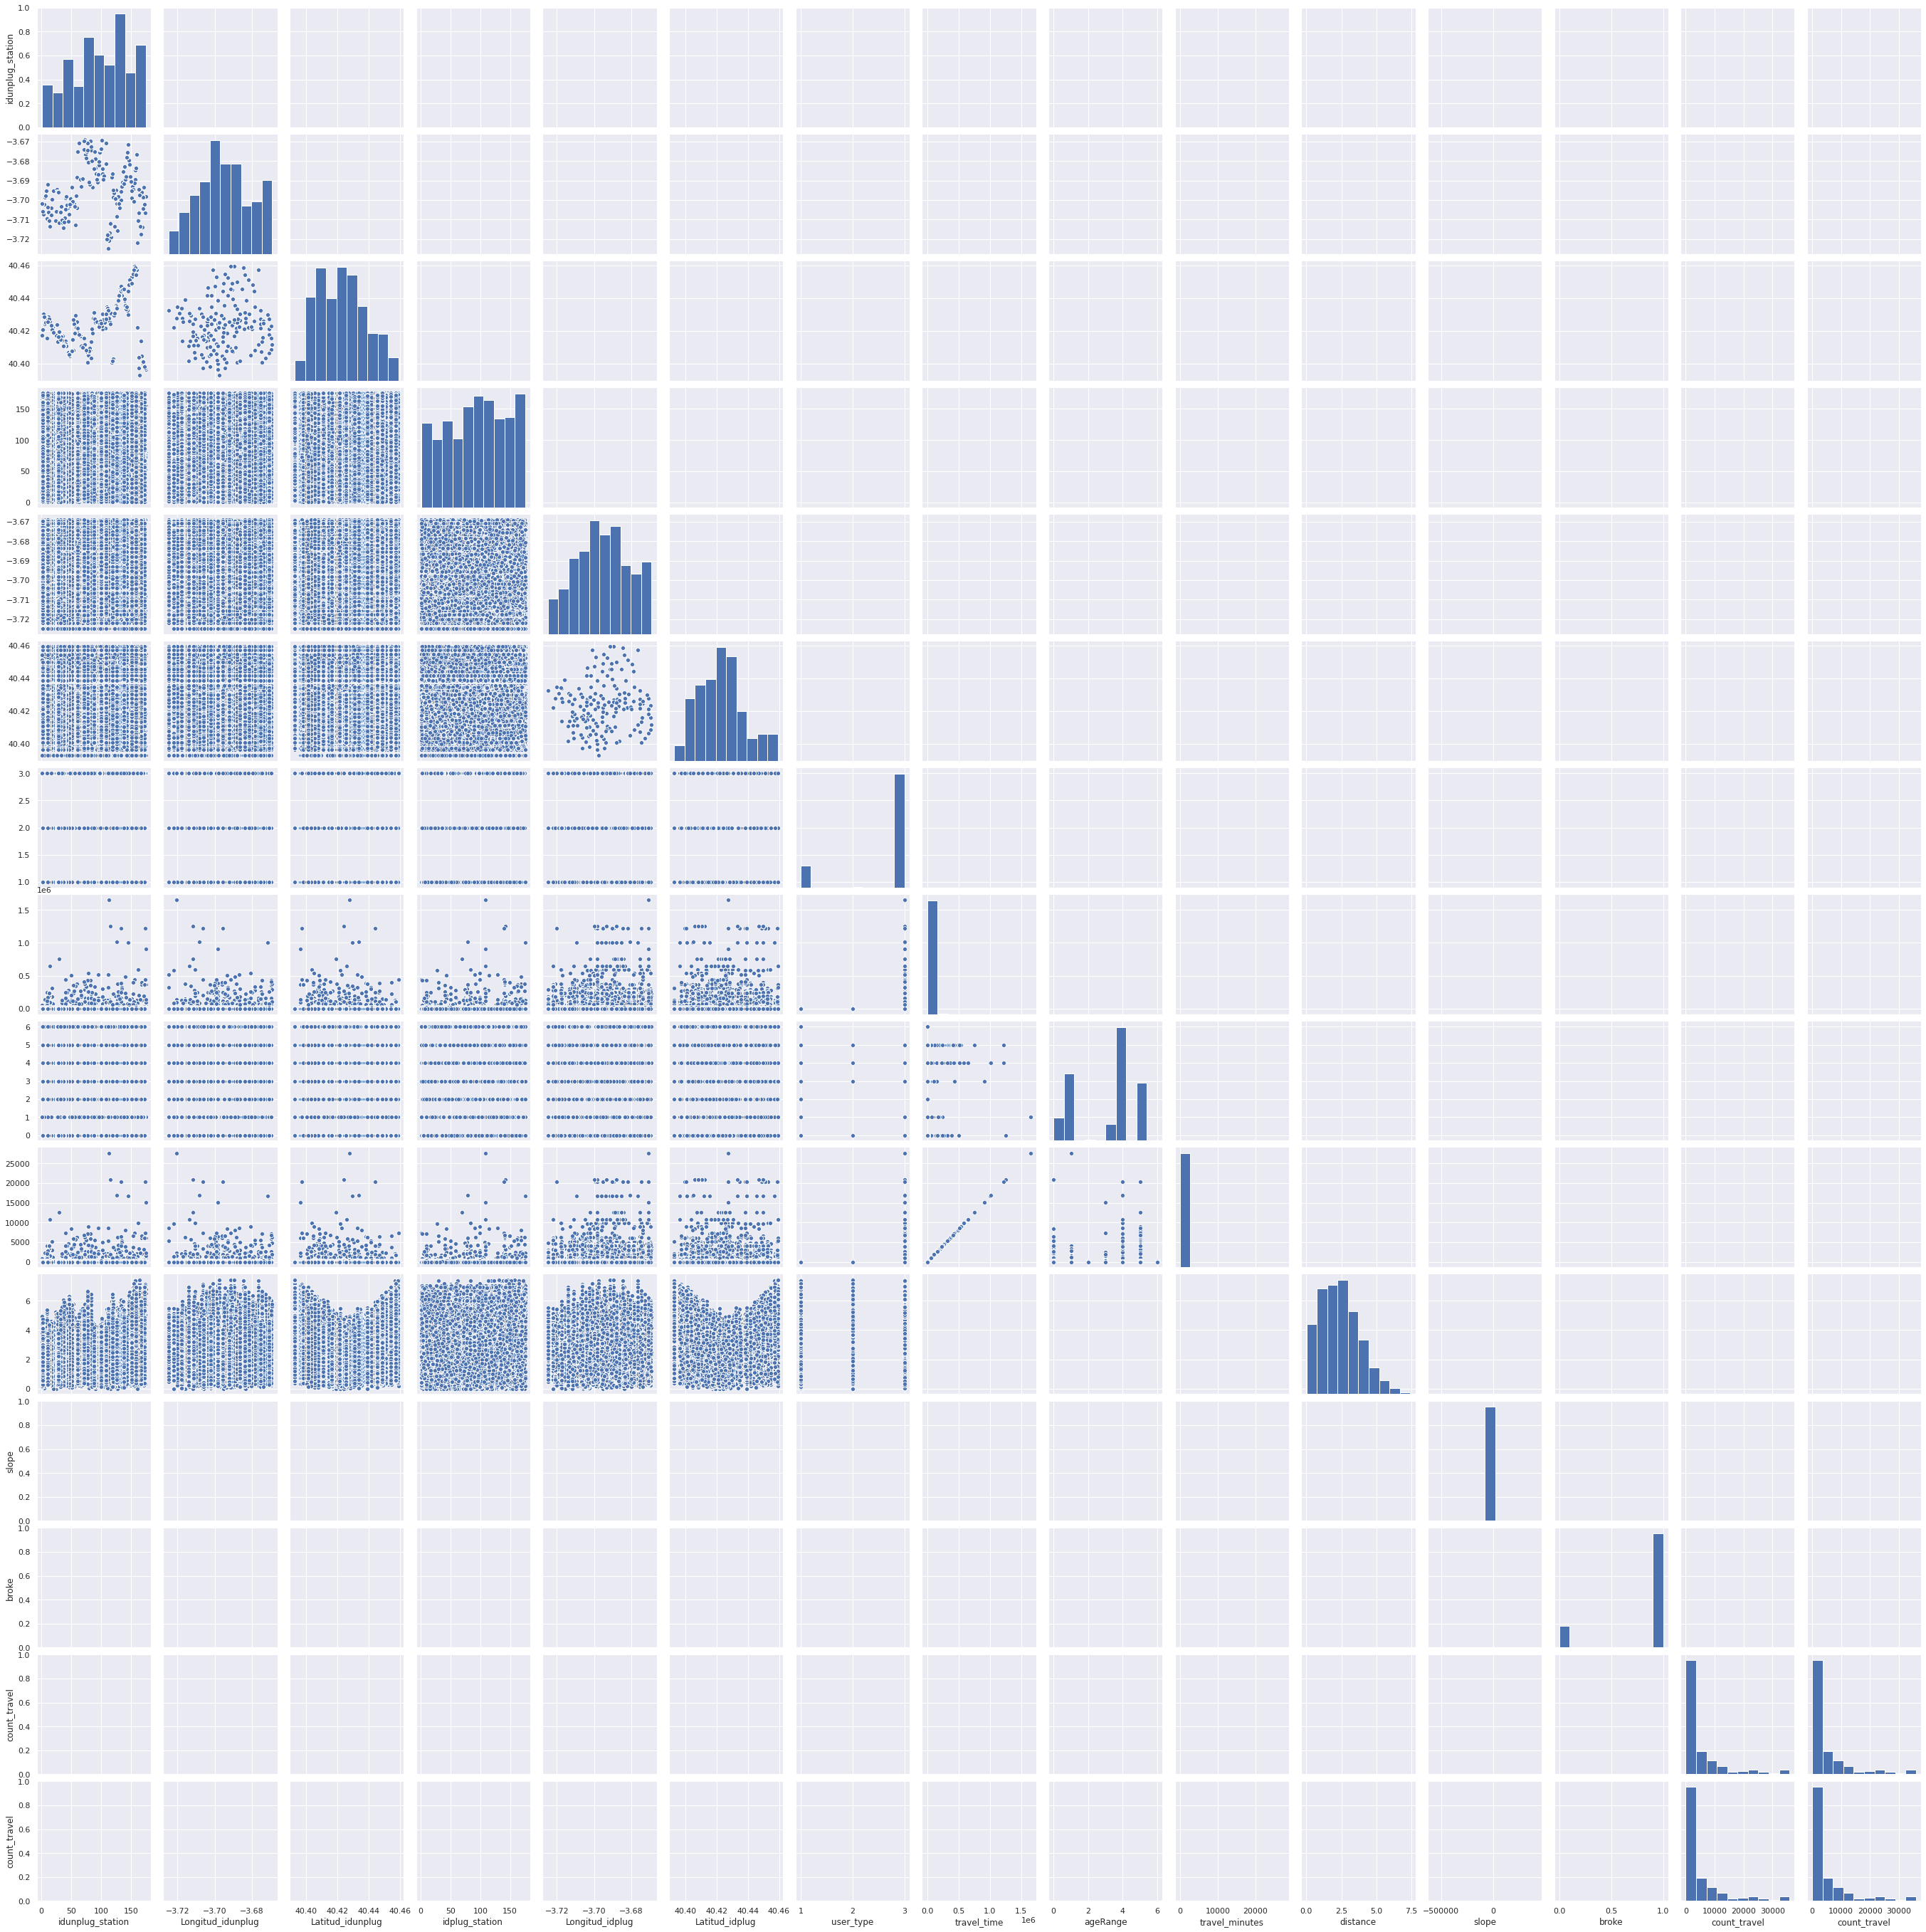

In [ ]:
%%time
sns.set()
sns.pairplot(data)

## Machine Learning Models

##### Logistic Regression ML (1)

This is Logistic Regression with split test and train. The total observations is 2926629 and 22 columns.

Objective variable: user_type

Feautures: travel_minutes, distance, count_travel

                precision    recall  f1-score   support

           1       0.98      1.00      0.99    160080
           2       0.00      0.00      0.00      1874
           3       1.00      1.00      1.00    716035

Este modelo trata de predecir el tipo de usuario en función de las variables distancia, tiempo minutos, edad y total de viajes. Tiene una buena precisión global de 0.99.
No obstante, no tiene buena Precisión, Recall ni f1-score cuando tiene que predecir en el perfil 2.



In [ ]:
data.shape

(2926629, 22)

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
y1 = data['user_type'] 
x1 = data.loc[:,['travel_minutes', 'distance', 'count_travel']] 
class_names = y1.sort_values().unique()
# x1_train, y1_train, x1_test, y1_test = train_test_split(x1,y1, test_size=0.3, random_state=0) #error por el orden de la partición

In [99]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.30, random_state=0)

In [100]:
model1 = LogisticRegression(multi_class='ovr')
model1.fit(x1_train, y1_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
model1.coef_

array([[-0.00667322,  0.07112352, -0.01787264],
       [ 0.0005104 , -0.0814818 , -0.00726802],
       [ 0.00257102, -0.07203276,  0.0226889 ]])

In [102]:
model1.intercept_

array([ 4.27421844, -4.2149185 , -5.29668385])

In [105]:
model1.score(x1_train, y1_train)

0.9947985004686035

Accuracy_score: Mide la precisión global del modelo, en este caso es buena de un 0.99. No obstante la precisión, recall y f1-score para el tipo de usuario 2 no es buena.

In [106]:
from sklearn.metrics import accuracy_score
accuracy_score(y1_test, model1.predict(x1_test))

0.994791506499512

In [107]:
from sklearn.metrics import classification_report

print(classification_report(y1_test, model1.predict(x1_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.98      1.00      0.99    160080
           2       0.00      0.00      0.00      1874
           3       1.00      1.00      1.00    716035

    accuracy                           0.99    877989
   macro avg       0.66      0.66      0.66    877989
weighted avg       0.99      0.99      0.99    877989




En el **reporte de clasificación** podemos observar que para los usuarios anuales (1) tiene un *recall* 1.00 lo cual significa que encuentra el total de elementos de esta clase lo mismo ocurre con el grupo 3, los trabajadores de BiciMad. Mientras que para los usuarios ocasionales no encuentra el total de elementos.

En cuanto la *precisión*, es decir clasificar correctamente la clase, son altas en las clasificación del grupo 1 y 3. 

En cuanto *F1-Score*, es la armonia entre la precisión y recall, es bastante bueno para los grupos 1 y 3. 

El *support* es el número de muestras de la respuesta verdadera que se encuentran en esa clase.

In [118]:
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y1_test, model1.predict(x1_test))

array([[159502,      0,    578],
       [  1874,      0,      0],
       [  2121,      0, 713914]])

Confusion matrix, without normalization
[[159502      0    578]
 [  1874      0      0]
 [  2121      0 713914]]
Normalized confusion matrix
[[0.99638931 0.         0.00361069]
 [1.         0.         0.        ]
 [0.00296215 0.         0.99703785]]


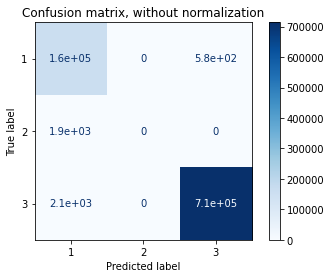

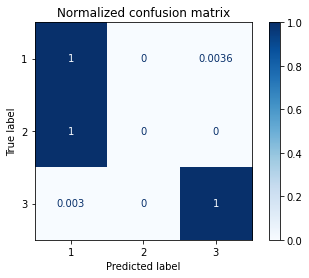

In [119]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model1, x1_test, y1_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)

    print(disp.confusion_matrix)

#### Logistic Regression ML (2)

This is Logistic Regression with split test and train. The total observations is 2926629 and 22 columns.

Objective variable: user_type

Feautures: distance, travel_minutes, ageRange, count_travel

                precision    recall  f1-score   support

           1       0.98      1.00      0.99    374466
           2       0.00      0.00      0.00      4450
           3       1.00      1.00      1.00   1669724

Este modelo trata de predecir el tipo de usuario en función de las variables distancia, tiempo minutos, edad y total de viajes. Tiene una buena precisión global de 1.00. No obstante, no tiene buena Precisión, Recall ni f1-score cuando tiene que predecir en el perfil 2.

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
y2 = data['user_type'] #objective
x2 = data.loc[:,['distance', 'travel_minutes', 'ageRange', 'count_travel']] # feautures

In [140]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.30, random_state=0) #split data

In [141]:
model2 = LogisticRegression() #creating a model2
model2.fit(x2_train, y2_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [142]:
model2.coef_

array([[ 0.03997651, -0.00513252,  0.34627869, -0.00547055],
       [ 0.12839414,  0.00256905, -0.94250512, -0.01242228],
       [-0.16837065,  0.00256347,  0.59622642,  0.01789283]])

In [143]:
model2.intercept_

array([ 3.17300579, -0.58548304, -2.58752275])

In [144]:
model2.score(x2_train,y2_train)

0.9950845438925335

In [145]:
# y2_pred = model2.predict(x2_test)
# confusion_matrix(y2_test, y2_pred)

In [146]:
from sklearn.metrics import classification_report
print(classification_report(y2_train, model2.predict(x2_train)))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99    374466
           2       0.00      0.00      0.00      4450
           3       1.00      1.00      1.00   1669724

    accuracy                           1.00   2048640
   macro avg       0.66      0.66      0.66   2048640
weighted avg       0.99      1.00      0.99   2048640



Confusion matrix, without normalization
[[159608      0    472]
 [  1874      0      0]
 [  1948     15 714072]]
Normalized confusion matrix
[[9.97051474e-01 0.00000000e+00 2.94852574e-03]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.72053740e-03 2.09486966e-05 9.97258514e-01]]


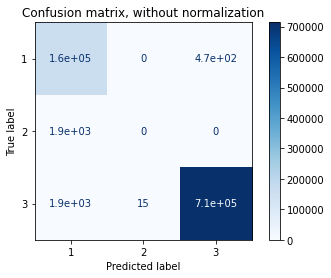

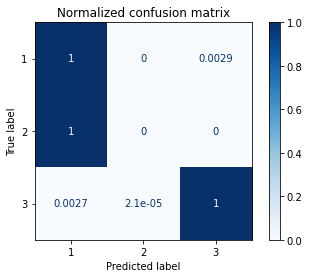

In [147]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model2, x2_test, y2_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)

    print(disp.confusion_matrix)

### Logistic Regression ML (3)

This is Logistic Regression with split test and train. The sample is balanced, the total observations is 18972 and 22 columns.

Objective variable: user_type

Feautures: travel_minutes, distance, count_travel

Este modelo trata de predecir el tipo de usuario en función de la variable tiempo en minutos, distancia y total de viajes. Tiene una buena precisión de 0.79. 

              precision    recall  f1-score   support

           1       0.65      0.87      0.74      4487
           2       0.80      0.52      0.63      4397
           3       1.00      1.00      1.00      4396

          


In [83]:
# balanced_data=data.groupby('user_type',as_index = False,group_keys=False).apply(lambda s: s.sample(6324,replace=True)) #to balance data

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

y3 = balanced_data['user_type']
x3 = balanced_data.loc[:,['travel_minutes', 'distance', 'count_travel']]

In [87]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.30, random_state=0) #split data

In [88]:
model3 = LogisticRegression()
model3.fit(x3_train,y3_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
model3.score(x3_train,y3_train)

0.797289156626506

In [90]:
y3_pred = model3.predict(x3_test)
confusion_matrix(y3_test, y3_pred)

array([[1601,  232,    4],
       [ 890, 1037,    0],
       [   6,    1, 1921]])

In [124]:
print(classification_report(y3_train, model3.predict(x3_train)))

              precision    recall  f1-score   support

           1       0.65      0.87      0.74      4487
           2       0.80      0.52      0.63      4397
           3       1.00      1.00      1.00      4396

    accuracy                           0.80     13280
   macro avg       0.82      0.80      0.79     13280
weighted avg       0.82      0.80      0.79     13280



Accuracy_score: Mide la precisión global del modelo, en este caso es buena de un 0.80

In [96]:
from sklearn.metrics import accuracy_score
accuracy_score(y3_test, model3.predict(x3_test))

0.800948699929726

Confusion matrix, without normalization
[[1601  232    4]
 [ 890 1037    0]
 [   6    1 1921]]
Normalized confusion matrix
[[8.71529668e-01 1.26292869e-01 2.17746326e-03]
 [4.61857810e-01 5.38142190e-01 0.00000000e+00]
 [3.11203320e-03 5.18672199e-04 9.96369295e-01]]


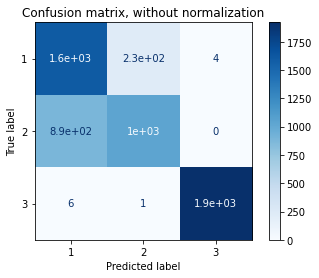

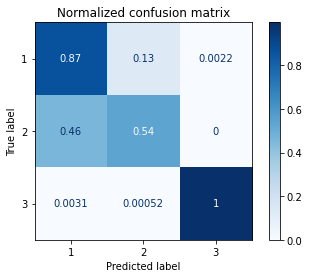

In [121]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model3, x3_test, y3_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)

    print(disp.confusion_matrix)

Diagonal principal evaluaciones correctas de cada una de las clases, Verdaderos Positivos. 



### **Logistic Regression ML (4)**
This is Logistic Regression with split test and train. The sample is balanced. The sample is balanced, the total observations is 18972 and 22 columns.

Objective variable: user_type

Feautures: distance, travel_minutes, ageRange, count_travel

Este modelo trata de predecir el tipo de usuario en función de las variables distancia, tiempo minutos, edad y total de viajes. Tiene una buena precisión global de 0.88. 

                precision    recall  f1-score   support

           1       0.95      0.70      0.81      4487
           2       0.76      0.97      0.85      4397
           3       1.00      0.99      1.00      4396



           


In [209]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
y4 = balanced_data['user_type'] #objective
x4 = balanced_data.loc[:,['distance', 'travel_minutes', 'ageRange', 'count_travel']] 

In [210]:
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y4, test_size=0.30, random_state=0) #split data

In [211]:
model4 = LogisticRegression() #creating a model2
model4.fit(x4_train, y4_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [212]:
model4.score(x4_train,y4_train)

0.8860692771084338

In [213]:
from sklearn.metrics import classification_report
print(classification_report(y4_train, model4.predict(x4_train)))

              precision    recall  f1-score   support

           1       0.95      0.70      0.81      4487
           2       0.76      0.97      0.85      4397
           3       1.00      0.99      1.00      4396

    accuracy                           0.89     13280
   macro avg       0.90      0.89      0.88     13280
weighted avg       0.90      0.89      0.88     13280



Confusion matrix, without normalization
[[1272  560    5]
 [  48 1877    2]
 [   9    0 1919]]
Normalized confusion matrix
[[0.69243332 0.30484486 0.00272183]
 [0.02490919 0.97405293 0.00103788]
 [0.00466805 0.         0.99533195]]


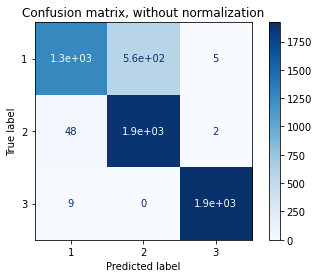

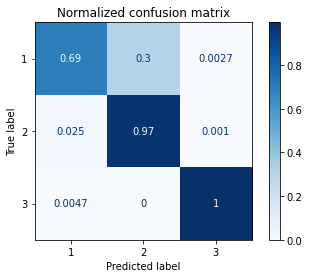

In [214]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model4, x4_test, y4_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)

    print(disp.confusion_matrix)

### K Nearest Neighbor Classifier (5)

This is K Nearest Neighbor Classifier with split test and train. The total observations is 2926629 and 22 columns.

Objective variable: user_type

Feautures: travel_minutes, distance, count_travel


                precision    recall  f1-score   support

           1       0.99      1.00      0.99    160080
           2       0.35      0.15      0.21      1874
           3       1.00      1.00      1.00    716035

In [150]:
from sklearn.neighbors import KNeighborsClassifier
y5 = data['user_type'] 
x5 = data.loc[:,['travel_minutes', 'distance', 'count_travel']] 
class_names = y5.sort_values().unique()

In [149]:
x5_train, x5_test, y5_train, y5_test = train_test_split(x5, y5, test_size=0.30, random_state=0)

In [151]:
model5 = KNeighborsClassifier(n_neighbors=3) #create model

In [153]:
model5.fit(x5_train, y5_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [154]:
pred5 = model5.predict(x5_test) #predict values 

In [157]:
model5.score(x5_train, y5_train)

0.9982075913776944

In [158]:
model5.score(x5_test, y5_test)

0.9972562298616497

In [156]:
confusion_matrix(y5_test, pred5)

array([[159413,    542,    125],
       [  1587,    287,      0],
       [   154,      1, 715880]])

In [160]:
print(classification_report(y5_test, pred5))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99    160080
           2       0.35      0.15      0.21      1874
           3       1.00      1.00      1.00    716035

    accuracy                           1.00    877989
   macro avg       0.78      0.72      0.73    877989
weighted avg       1.00      1.00      1.00    877989



### **K Nearest Neighbor Classifier (6)**

This is K Nearest Neighbor Classifier with split test and train. The total observations is 2926629 and 22 columns.

Objective variable: user_type

Feautures: distance, travel_minutes, ageRange, count_travel


                precision    recall  f1-score   support

           1       0.99      1.00      0.99    160080
           2       0.40      0.23      0.29      1874
           3       1.00      1.00      1.00    716035

In [215]:
from sklearn.neighbors import KNeighborsClassifier
y6 = data['user_type'] 
x6 = data.loc[:,['distance','travel_minutes', 'ageRange','count_travel']] 
class_names = y5.sort_values().unique()

In [216]:
x6_train, x6_test, y6_train, y6_test = train_test_split(x6, y6, test_size=0.30, random_state=0)

In [217]:
model6 = KNeighborsClassifier(n_neighbors=3) #create model

In [218]:
model6.fit(x6_train, y6_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [219]:
pred6 = model6.predict(x6_test) #predict values 

In [220]:
model6.score(x6_train, y6_train)

0.9984365237425804

In [221]:
model6.score(x6_test, y6_test)

0.997497690745556

In [222]:
confusion_matrix(y6_test, pred6)

array([[159404,    630,     46],
       [  1446,    428,      0],
       [    75,      0, 715960]])

In [223]:
print(classification_report(y6_test, pred6))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99    160080
           2       0.40      0.23      0.29      1874
           3       1.00      1.00      1.00    716035

    accuracy                           1.00    877989
   macro avg       0.80      0.74      0.76    877989
weighted avg       1.00      1.00      1.00    877989



Confusion matrix, without normalization
[[159404    630     46]
 [  1446    428      0]
 [    75      0 715960]]
Normalized confusion matrix
[[9.95777111e-01 3.93553223e-03 2.87356322e-04]
 [7.71611526e-01 2.28388474e-01 0.00000000e+00]
 [1.04743483e-04 0.00000000e+00 9.99895257e-01]]


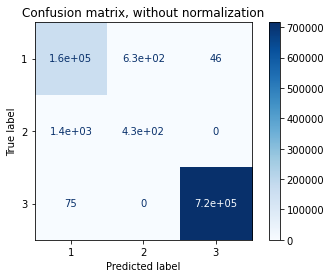

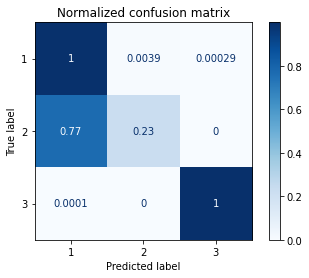

In [224]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model6, x6_test, y6_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)

    print(disp.confusion_matrix)

### K Nearest Neighbor Classifier (7)

This is K Nearest Neighbor Classifier with split test and train. The sample is balanced. The sample is balanced, the total observations is 18972 and 22 columns.

Objective variable: user_type

Feautures: travel_minutes, distance, count_travel


                precision    recall  f1-score   support

           1       0.78      0.72      0.75      1837
           2       0.75      0.81      0.78      1927
           3       1.00      1.00      1.00      1928

In [225]:
from sklearn.neighbors import KNeighborsClassifier
y7 = balanced_data['user_type'] 
x7 = balanced_data.loc[:,['travel_minutes', 'distance', 'count_travel']] 
class_names = y7.sort_values().unique()

In [226]:
x7_train, x7_test, y7_train, y7_test = train_test_split(x7, y7, test_size=0.30, random_state=0)

In [227]:
model7 = KNeighborsClassifier(n_neighbors=3) #create model

In [228]:
model7.fit(x7_train, y7_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [229]:
pred7 = model7.predict(x7_test) #predict values 

In [230]:
model7.score(x7_train, y7_train)

0.913328313253012

In [231]:
model7.score(x7_test, y7_test)

0.8441672522839072

In [232]:
confusion_matrix(y7_test, pred7)

array([[1329,  505,    3],
       [ 374, 1553,    0],
       [   5,    0, 1923]])

In [233]:
print(classification_report(y7_test, pred7))

              precision    recall  f1-score   support

           1       0.78      0.72      0.75      1837
           2       0.75      0.81      0.78      1927
           3       1.00      1.00      1.00      1928

    accuracy                           0.84      5692
   macro avg       0.84      0.84      0.84      5692
weighted avg       0.84      0.84      0.84      5692



Confusion matrix, without normalization
[[1329  505    3]
 [ 374 1553    0]
 [   5    0 1923]]
Normalized confusion matrix
[[0.72346217 0.27490474 0.0016331 ]
 [0.19408407 0.80591593 0.        ]
 [0.00259336 0.         0.99740664]]


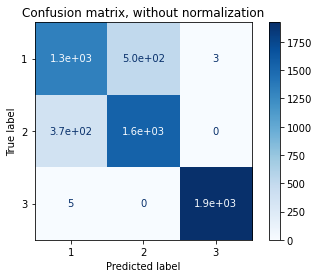

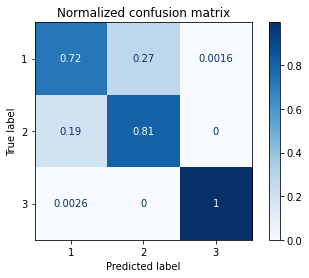

In [234]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model7, x7_test, y7_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)

    print(disp.confusion_matrix)

## **K Nearest Neighbor Classifier (8**)

This is K Nearest Neighbor Classifier with split test and train.  The sample is balanced. The sample is balanced, the total observations is 18972 and 22 columns.

Objective variable: user_type

Feautures: distance, travel_minutes, ageRange, count_travel

                precision    recall  f1-score   support

           1       0.89      0.80      0.84      1837
           2       0.83      0.90      0.86      1927
           3       1.00      1.00      1.00      1928
               

In [235]:
from sklearn.neighbors import KNeighborsClassifier
y8 = balanced_data['user_type'] 
x8 = balanced_data.loc[:,['distance','travel_minutes', 'ageRange','count_travel']] 
class_names = y8.sort_values().unique()

In [236]:
x8_train, x8_test, y8_train, y8_test = train_test_split(x8, y8, test_size=0.30, random_state=0)

In [237]:
model8 = KNeighborsClassifier(n_neighbors=3) #create model

In [238]:
model8.fit(x8_train, y8_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [239]:
pred8 = model8.predict(x8_test) #predict values 

In [240]:
model8.score(x8_train, y8_train)

0.9441265060240964

In [241]:
model8.score(x8_test, y8_test)

0.9016163035839775

In [242]:
confusion_matrix(y8_test, pred8)

array([[1467,  368,    2],
       [ 185, 1742,    0],
       [   5,    0, 1923]])

In [243]:
print(classification_report(y8_test, pred8))

              precision    recall  f1-score   support

           1       0.89      0.80      0.84      1837
           2       0.83      0.90      0.86      1927
           3       1.00      1.00      1.00      1928

    accuracy                           0.90      5692
   macro avg       0.90      0.90      0.90      5692
weighted avg       0.90      0.90      0.90      5692



Confusion matrix, without normalization
[[1467  368    2]
 [ 185 1742    0]
 [   5    0 1923]]
Normalized confusion matrix
[[0.79858465 0.20032662 0.00108873]
 [0.09600415 0.90399585 0.        ]
 [0.00259336 0.         0.99740664]]


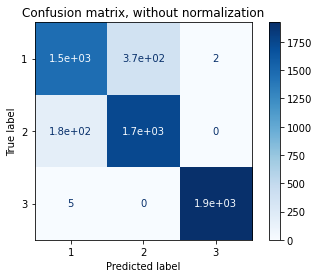

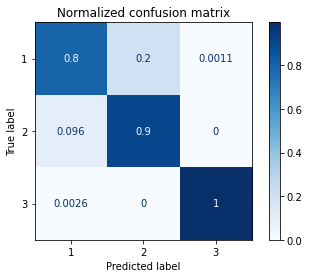

In [244]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model8, x8_test, y8_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)

    print(disp.confusion_matrix)

# Streamlit


In [ ]:
!pip install -q streamlit


     |████████████████████████████████| 7.2MB 6.9MB/s 
     |████████████████████████████████| 4.4MB 42.6MB/s 
     |████████████████████████████████| 112kB 53.0MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 122kB 50.4MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.3.4 which is incompatible.


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -qq ngrok-stable-linux-amd64.zip

--2020-08-25 21:25:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.153.26.168, 34.205.126.213, 54.236.206.131, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.153.26.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  48.4MB/s    in 0.3s    

2020-08-25 21:25:39 (48.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]



In [ ]:
!pip install streamlit-folium #streamlit with folium

     |████████████████████████████████| 102kB 2.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.11.0 which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://1e2714a46f1c.ngrok.io


In [ ]:
%%file BiciMad.py
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
import folium.plugins
import plotly.express as px
# from bokeh.plotting import figure, output_file, show
from streamlit_folium import folium_static

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/originalbikestations.csv", sep=';', encoding='utf-8')
df['Year'] = pd.DatetimeIndex(df['Fecha de Alta']).year
year = df['Year']
df = df.rename(columns = {'Número':'id','Número de Plazas':'Anclajes'}) #change de name of column Número
df['ids'] = df['id'].str.rstrip('ampliacionb') #to get only number values
# df_stations = df_stations[onlycolumns]
df['ids'] = df['ids'].astype(int).sort_values() #change values ids and order

d_b = df.groupby(['Distrito'])['Barrio'].count()

locations = df[['LATITUD', 'LONGITUD']] # (Y, X)
locationlist = locations.values.tolist()
df['Locationlist'] = locationlist

st.title("Bici Madrid by: Raquel Socorro")

# fig = plt.figure()
# fig.add_axes(langs)
langs = ['CENTRO', 'ARGANZUELA', 'RETIRO', 'SALAMANCA', 'CHAMARTÍN', 'TETUÁN', 'CHAMBERÍ', 'MONCLOA-ARAVACA', 'PUENTE DE VALLECAS', 'CIUDAD LINEAL']
# ax.bar(langs,aa)
# plt.show()
# p = plt.figure()
# p.set_figheight(10)
# p.set_figwidth(25)
# p.set_facecolor('white')
# y_pos = np.arange(len(langs))
# plt.bar(y_pos, d_b, align='center', alpha=0.5, width=0.8, color = 'gray')
# plt.xticks(y_pos, langs)
# plt.ylabel('Station by Barrio')
# plt.title('Bike Station by Distrito')

# plt.show()
# st.bokeh_chart(p)
st.title("Puntos de estacionamientos por Distrito")
map1 = folium.Map(location=[40.417110795315295, -3.70199802576925], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['Distrito'][point], icon=folium.Icon(color='darkblue', icon_color='white', icon='bicycle', angle=0, prefix='fa')).add_to(map1)
folium_static(map1) 


st.title("Puntos de anclajes por Distrito")
import folium.plugins
folium.plugins.MarkerCluster()
map2 = folium.Map(location=[40.417110795315295, -3.70199802576925], tiles='Stamen Terrain', zoom_start=11)

marker_cluster = folium.plugins.MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['Distrito'][point], icon=folium.Icon(color='darkblue', icon_color='green', icon='bicycle', angle=0, prefix='fa')).add_to(marker_cluster)
folium_static(map2)



import plotly.express as px
fig2 = px.scatter_geo(df, locations=df['Locationlist'], locationmode='country names', color= df['Distrito'].sort_values(), hover_name=df['Calle'],
                     size=df['Anclajes'], scope='europe', 
                     animation_frame=df['Year'].sort_values(), 
                     projection='stereographic')
# (df, locations="Locationlist", hover_name="Distrito", animation_frame="Year", projection="natural earth")
# folium_static(fig2)


Overwriting BiciMad.py


In [ ]:
!streamlit run BiciMad.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.227.52.181:8501

  Stopping...
  Stopping...


# Jan19

### Load Jan19 Dataset 

In [ ]:
jan19 = pd.read_json("/content/drive/My Drive/Colab Notebooks/data/jan19.json", encoding='latin-1', lines=True, dtype='frame')

In [ ]:
jan19.columns

Index(['_id', 'user_day_code', 'idplug_base', 'track', 'user_type',
       'idunplug_base', 'travel_time', 'idunplug_station', 'ageRange',
       'idplug_station', 'unplug_hourTime', 'zip_code'],
      dtype='object')

In [ ]:
# Save of position in _id column 
position = dict(enumerate(jan19['_id'].values))
position
type(position)
ids = []
# Save of values in its position 
ids = []
for d, v in position.items():
    ids += list(v.values())
#Save in the column _id
jan19['_id'] = ids 
na_columns = ['_id', 'user_day_code', 'idunplug_station', 'idunplug_base', 'idplug_station', 'idplug_base',
   'user_type','travel_time','unplug_hourTime', 'ageRange', 'zip_code']
jan19 = jan19[na_columns]
jan19 = jan19.rename(columns = {'_id':'id'})


In [ ]:
jan19.head()

,id,user_day_code,idunplug_station,idunplug_base,idplug_station,idplug_base,user_type,travel_time,unplug_hourTime,ageRange,zip_code
0,5c4b07ea2f38432e007daab8,b3b5b61509ab89afbf4d1e589d229bebe6637c2de819f5...,82,23,83,14,1,162,{'$date': '2019-01-01T00:00:00.000+0100'},0,
1,5c4b07ea2f38432e007daaba,a18550d468153bb8e1808d4f0a85955579951832772996...,133,1,36,10,1,415,{'$date': '2019-01-01T00:00:00.000+0100'},5,28005
2,5c4b07ea2f38432e007daabb,905737396c2fe343c84d62eaee3ab66e19632638c5bea7...,25,3,90,5,1,545,{'$date': '2019-01-01T00:00:00.000+0100'},0,
3,5c4b07ea2f38432e007daabd,5922b4a1a2591161ebf1ad66f42f52cc7796f3754c2c76...,105,6,155,18,1,417,{'$date': '2019-01-01T00:00:00.000+0100'},3,28009
4,5c4b07ea2f38432e007daabe,ed1c1a22c120e7d42cc522c33ab41db549791f3914b273...,51,12,44,4,1,448,{'$date': '2019-01-01T00:00:00.000+0100'},4,28005


In [ ]:
new_dataset19 = pd.merge(jan19, stations_2019, on='idunplug_station')  #join jan18 and stations_2019 using idunplug_station
new_dataset19 = new_dataset19.rename(columns={'Gis_X':'Gis_Xidunplug',
       'Gis_Y':'Gis_Yidunplug', 'Fecha de Alta':'Fecha de Alta_idunplug', 'Distrito':'Distrito_idunplug', 'Barrio':'Barrio_idunplug', 'Calle':'Calle_idunplug', 'Nº Finca':'Nº Finca_idunplug',
        'Anclajes':'Anclajes_idunplug', 'LONGITUD':'Longitud_idunplug', 'LATITUD':'Latitud_idunplug', 'DIRECCION':'DIRECCION_idunplug',
       'Year':'Year_idunplug', 'Locationlist':'Locationlist_idunplug', 'X':'X_idunplug', 'Y':'Y_idunplug'}) #change de name of the columns
del new_dataset19['ids']

another_dataset19 = pd.merge(jan19,stations_2019, on = 'idplug_station')

another_dataset19 = another_dataset19.rename(columns={'Gis_X':'Gis_Xidplug',
       'Gis_Y':'Gis_Yidplug', 'Fecha de Alta':'Fecha de Alta_idplug', 'Distrito':'Distrito_idplug', 'Barrio':'Barrio_idplug', 'Calle':'Calle_idplug', 'Nº Finca':'Nº Finca_idplug',
        'Anclajes':'Anclajes_idplug', 'LONGITUD':'Longitud_idplug', 'LATITUD':'Latitud_idplug', 'DIRECCION':'DIRECCION_idplug',
       'Year':'Year_idplug', 'Locationlist':'Locationlist_idplug', 'X':'X_idplug', 'Y':'Y_idplug'})
del another_dataset19['ids']

# another_dataset19.to_csv("another_dataset19")
# new_dataset19.to_csv("new_dataset19")# to save

data19 = pd.merge(new_dataset19, another_dataset19, on=['user_day_code'])
this_columns19 = ['id_x_x', 'user_day_code', 'idunplug_station', 'Distrito_idunplug', 'Barrio_idunplug','Longitud_idunplug', 'Latitud_idunplug', 
              'idplug_station_x', 'Distrito_idplug', 'Barrio_idplug', 'Longitud_idplug', 'Latitud_idplug',
               'user_type_x', 'travel_time_x','unplug_hourTime_x', 'ageRange_x', 'zip_code_x' ]
data19 = data19[this_columns19]
data19 = data19.rename(columns={'id_x_x':'_id','idplug_station_x':'idplug_station', 'user_type_x':'user_type', 'travel_time_x':'travel_time',
       'unplug_hourTime_x':'unplug_hourTime', 'ageRange_x':'ageRange', 'zip_code_x':'zip_code'})

In [ ]:
data19.columns

Index(['_id', 'user_day_code', 'idunplug_station', 'Distrito_idunplug',
       'Barrio_idunplug', 'Longitud_idunplug', 'Latitud_idunplug',
       'idplug_station', 'Distrito_idplug', 'Barrio_idplug', 'Longitud_idplug',
       'Latitud_idplug', 'user_type', 'travel_time', 'unplug_hourTime',
       'ageRange', 'zip_code'],
      dtype='object')

In [ ]:
data19.head(1)

,_id,user_day_code,idunplug_station,Distrito_idunplug,Barrio_idunplug,Longitud_idunplug,Latitud_idunplug,idplug_station,Distrito_idplug,Barrio_idplug,Longitud_idplug,Latitud_idplug,user_type,travel_time,unplug_hourTime,ageRange,zip_code
0,5c4b07ea2f38432e007daab8,b3b5b61509ab89afbf4d1e589d229bebe6637c2de819f5...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,83,03 RETIRO,03-06 NIÑO JESÚS,-3.674534,40.413259,1,162,{'$date': '2019-01-01T00:00:00.000+0100'},0,


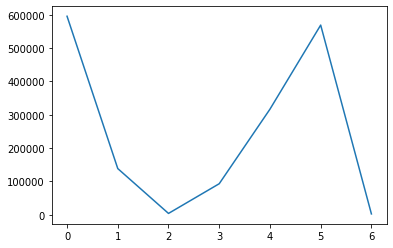

In [ ]:
plt.plot(data19.groupby('ageRange')['user_day_code'].count())

In [ ]:
#Calculate KMs 
from numpy import cos, sin, arcsin, sqrt
from math import radians

def haversine(data19):
  lon1 = data19['Longitud_idunplug']
  lat1 = data19['Latitud_idunplug']
  lon2 = data19['Longitud_idplug']
  lat2 = data19['Latitud_idplug']
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) #change a radians
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * arcsin(sqrt(a))
  km = 6367 * c # Tierra es una esfera perfecta de radio RT = 6367
  return km 

In [ ]:
data19['distance'] = data19.apply(lambda data19: haversine(data19), axis=1)

In [ ]:
data19.distance

0          0.671251
1          2.514487
2          2.514487
3          2.514487
4          2.514487
             ...   
1719646    1.213960
1719647    2.607995
1719648    2.129070
1719649    0.511951
1719650    2.989298
Name: distance, Length: 1719651, dtype: float64

In [ ]:
data19.columns

Index(['_id', 'user_day_code', 'idunplug_station', 'Distrito_idunplug',
       'Barrio_idunplug', 'Longitud_idunplug', 'Latitud_idunplug',
       'idplug_station', 'Distrito_idplug', 'Barrio_idplug', 'Longitud_idplug',
       'Latitud_idplug', 'user_type', 'travel_time', 'unplug_hourTime',
       'ageRange', 'zip_code', 'distance'],
      dtype='object')

In [ ]:
data19.groupby(['user_type', 'ageRange']).size()

user_type  ageRange
0          0             8041
1          0           255141
           1             1057
           2             4048
           3            33437
           4           170608
           5           121324
           6             2585
2          0             4077
           2                5
           3               20
           4               55
           5               26
3          0           328254
           1           137533
           3            59709
           4           146080
           5           447651
dtype: int64

In [ ]:
prediction19_1 = data19[['distance']]

In [ ]:
data19.head()

,_id,user_day_code,idunplug_station,Distrito_idunplug,Barrio_idunplug,Longitud_idunplug,Latitud_idunplug,idplug_station,Distrito_idplug,Barrio_idplug,Longitud_idplug,Latitud_idplug,user_type,travel_time,unplug_hourTime,ageRange,zip_code,distance
0,5c4b07ea2f38432e007daab8,b3b5b61509ab89afbf4d1e589d229bebe6637c2de819f5...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,83,03 RETIRO,03-06 NIÑO JESÚS,-3.674534,40.413259,1,162,{'$date': '2019-01-01T00:00:00.000+0100'},0,,0.671251
1,5c4b07ec2f38432e007dac38,7e2c9e2900682111af50a0cb5ddaf1b2e4b4cdbdddf82b...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,41,01 CENTRO,01-02 EMBAJADORES,-3.698990,40.412228,1,3160,{'$date': '2019-01-01T00:00:00.000+0100'},4,28005,2.514487
2,5c4b07ec2f38432e007dac38,7e2c9e2900682111af50a0cb5ddaf1b2e4b4cdbdddf82b...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,41,01 CENTRO,01-02 EMBAJADORES,-3.698990,40.412228,1,3160,{'$date': '2019-01-01T00:00:00.000+0100'},4,28005,2.514487
3,5c4b07fc2f38432e007db98d,7e2c9e2900682111af50a0cb5ddaf1b2e4b4cdbdddf82b...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,41,01 CENTRO,01-02 EMBAJADORES,-3.698990,40.412228,1,1319,{'$date': '2019-01-01T18:00:00.000+0100'},4,28005,2.514487
4,5c4b07fc2f38432e007db98d,7e2c9e2900682111af50a0cb5ddaf1b2e4b4cdbdddf82b...,82,03 RETIRO,03-03 ESTRELLA,-3.669683,40.408479,41,01 CENTRO,01-02 EMBAJADORES,-3.698990,40.412228,1,1319,{'$date': '2019-01-01T18:00:00.000+0100'},4,28005,2.514487


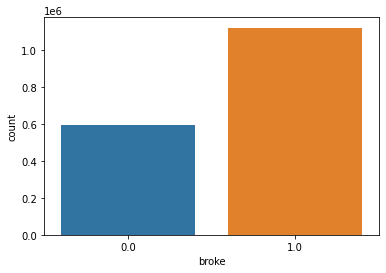

In [ ]:
broke_dict = {3:1, 2:0, 1:0}
data19['broke'] = data19.user_type.map(broke_dict)
data19['broke'].unique()
jan19_broke = sns.countplot(x='broke', data=data19)
jan19_broke

In [ ]:
predictions2 = jan19[['idunplug_station']]

In [ ]:
# predict_2 = reg2.predict(jan18[['idunplug_station']])
# predict2 = reg2.predict([predictions2])

In [ ]:
jan18['predictions2'] = predict_2

In [ ]:
jan18.head()

In [ ]:
jan18.loc[:, ['idunplug_station','idplug_station']]

#### Working with users use the bike with most frequence

In [ ]:
mostfreque_user.head()

In [ ]:
from sklearn.metrics import mean_absolute_error
# Use against predictions
error2 = mean_absolute_error(reg2.predict(X_tr), y_tr)

### Random 

In [ ]:
predictions=jan19[['idunplug_station']].head(263701)
predictions19 = reg.predict(predictions)
jan18['predictions19'] = predictions19

In [ ]:
lm2 = sm.OLS(y_tr, sm.add_constant(X_tr))

In [ ]:
lm_model2 = lm2.fit()
lm_model2.summary()

# Jan 20

In [ ]:
jan20 = pd.read_json("/content/drive/My Drive/Colab Notebooks/data/202001_movements.json", encoding='latin-1', lines=True)


In [ ]:
jan20.head()

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,unplug_hourTime,zip_code
0,{'$oid': '5eeb03e42ea8f656fc95f2a4'},c87385356e6eb4b9854a2e64f719017d1023e3de201abb...,1,1,21,210,87,2,78,2020-01-01T00:00:00Z,28007
1,{'$oid': '5eeb03e42ea8f656fc95f2a7'},35190181c1ada5deae3e8d51d05aee4090267969a20975...,1,1,21,401,58,4,168,2020-01-01T00:00:00Z,28004
2,{'$oid': '5eeb03e42ea8f656fc95f2aa'},f77e4af707dfc3753aea3a3964923f256ef9c0be141399...,19,1,23,473,129,4,82,2020-01-01T00:00:00Z,28045
3,{'$oid': '5eeb03e42ea8f656fc95f2ad'},b7ff183e57cd412f698349540a4c729d0e4e396f4fc586...,1,1,19,285,208,4,8,2020-01-01T00:00:00Z,28004
4,{'$oid': '5eeb03e42ea8f656fc95f2b1'},f272ac2e59e493866254c364c86253edd7fae80ff4706f...,12,1,8,436,9,4,166,2020-01-01T00:00:00Z,28020


In [ ]:
# Save of position in _id column 
position = dict(enumerate(jan20['_id'].values))
position
type(position)
ids = []
# Save of values in its position 
ids = []
for d, v in position.items():
    ids += list(v.values())
#Save in the column _id
jan20['_id'] = ids 
na_columns = ['_id', 'user_day_code', 'idunplug_station', 'idunplug_base', 'idplug_station', 'idplug_base',
   'user_type','travel_time','unplug_hourTime', 'ageRange', 'zip_code']
jan20 = jan20[na_columns]
jan20 = jan20.rename(columns = {'_id':'id'})

In [ ]:
# new_dataset20 = pd.merge(jan20, stations_2019, on='idunplug_station')  #join jan18 and stations_2019 using idunplug_station
# new_dataset20 = new_dataset19.rename(columns={'Gis_X':'Gis_Xidunplug',
#        'Gis_Y':'Gis_Yidunplug', 'Fecha de Alta':'Fecha de Alta_idunplug', 'Distrito':'Distrito_idunplug', 'Barrio':'Barrio_idunplug', 'Calle':'Calle_idunplug', 'Nº Finca':'Nº Finca_idunplug',
#         'Anclajes':'Anclajes_idunplug', 'LONGITUD':'Longitud_idunplug', 'LATITUD':'Latitud_idunplug', 'DIRECCION':'DIRECCION_idunplug',
#        'Year':'Year_idunplug', 'Locationlist':'Locationlist_idunplug', 'X':'X_idunplug', 'Y':'Y_idunplug'}) #change de name of the columns
# del new_dataset19['ids']

# another_dataset19 = pd.merge(jan19,stations_2019, on = 'idplug_station')

# another_dataset19 = another_dataset19.rename(columns={'Gis_X':'Gis_Xidplug',
#        'Gis_Y':'Gis_Yidplug', 'Fecha de Alta':'Fecha de Alta_idplug', 'Distrito':'Distrito_idplug', 'Barrio':'Barrio_idplug', 'Calle':'Calle_idplug', 'Nº Finca':'Nº Finca_idplug',
#         'Anclajes':'Anclajes_idplug', 'LONGITUD':'Longitud_idplug', 'LATITUD':'Latitud_idplug', 'DIRECCION':'DIRECCION_idplug',
#        'Year':'Year_idplug', 'Locationlist':'Locationlist_idplug', 'X':'X_idplug', 'Y':'Y_idplug'})
# del another_dataset19['ids']

# # another_dataset19.to_csv("another_dataset19")
# # new_dataset19.to_csv("new_dataset19")# to save

# data19 = pd.merge(new_dataset19, another_dataset19, on=['user_day_code'])
# this_columns19 = ['id_x_x', 'user_day_code', 'idunplug_station', 'Distrito_idunplug', 'Barrio_idunplug','Longitud_idunplug', 'Latitud_idunplug', 
#               'idplug_station_x', 'Distrito_idplug', 'Barrio_idplug', 'Longitud_idplug', 'Latitud_idplug',
#                'user_type_x', 'travel_time_x','unplug_hourTime_x', 'ageRange_x', 'zip_code_x' ]
# data19 = data19[this_columns19]
# data19 = data19.rename(columns={'id_x_x':'_id','idplug_station_x':'idplug_station', 'user_type_x':'user_type', 'travel_time_x':'travel_time',
#        'unplug_hourTime_x':'unplug_hourTime', 'ageRange_x':'ageRange', 'zip_code_x':'zip_code'})

In [ ]:
jan20['user_type'].value_counts()
# data['user_type'].value_counts()

1    249537
3     22693
2       645
Name: user_type, dtype: int64

In [ ]:
data19['user_type'].value_counts()

3    1119227
1     588200
0       8041
2       4183
Name: user_type, dtype: int64

In [ ]:
data['user_type'].value_counts()

3    2385759
1     534546
2       6324
Name: user_type, dtype: int64

In [ ]:
from numpy import cos, sin, arcsin, sqrt
from math import radians

def haversine(data19):
  lon1 = jan20['Longitud_idunplug']
  lat1 = jan20['Latitud_idunplug']
  lon2 = jan20['Longitud_idplug']
  lat2 = jan20['Latitud_idplug']
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) #change a radians
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * arcsin(sqrt(a))
  km = 6367 * c # Tierra es una esfera perfecta de radio RT = 6367
  return km 

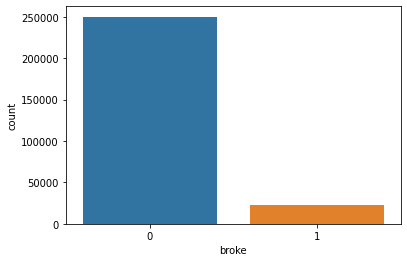

In [ ]:
broke_dict = {3:1, 2:0, 1:0}
jan20['broke'] = jan20.user_type.map(broke_dict)
jan20['broke'].unique()
jan20_broke = sns.countplot(x='broke', data=jan20)
jan20_broke

# Conecting into Mobility Lab API


In [ ]:
import requests

In [ ]:
# url = 'https://openapi.emtmadrid.es/v1/transport/bicimad/stations/<idStation>/'
resp = requests.get('https://openapi.emtmadrid.es/v1/transport/bicimad/stations/<idStation>/')
resp.content[:500]

b'{"code": "80", "description": "Error, token none not found in cache", "datetime": "2020-04-11T18:25:37.725984", "data": []}'

In [ ]:
r = requests.get('https://openapi.emtmadrid.es/v1/transport/bicimad/stations/<idStation>/')
r.status_code

200

In [ ]:
r.content

b'{"code": "80", "description": "Error, token none not found in cache", "datetime": "2020-04-11T18:27:46.344736", "data": []}'

In [ ]:
r = requests.get('https://openapi.emtmadrid.es/v1/mobilitylabs/collection/reactive/<idcollection>/<idlinkname>/')

In [ ]:
curl -X POST \


NameError: ignored

# Paquetes instalados

In [ ]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.8.1          
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.2.10         
astor                         0.8.1          
astropy                       4.0.1.post1    
astunparse                    1.6.3          
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.1.0         
audioread                     2.1.8          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.1.5          
blis                          0.4.1          
bokeh                         2.1.